In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [155]:
#Export
#!/data/users/machiyu/anaconda3/envs/Flask/bin/python

from support_f_and_m import *

In [3]:
#Export
app = Flask(__name__)
app.secret_key = os.getenv('SECRET_KEY', 'secret string')
app.jinja_env.trim_blocks =True
app.jinja_env.lstrip_blocks = True

In [4]:
#Export
app.config['MATRIX_UPLOAD_PATH'] = os.path.join(app.root_path, 'upload_file/matrix')
app.config['GENE_UPLOAD_PATH'] = os.path.join(app.root_path, 'upload_file/gene')
app.config['MATRIX_OUTPUT_PATH'] = os.path.join(app.root_path, 'output_result/matrix')
app.config['GENE_OUTPUT_PATH'] = os.path.join(app.root_path, 'output_result/gene')
app.config['MATRIX_ALLOWED_EXTENSIONS'] = ['xls','xlsx','csv','tsv']

os.makedirs(app.config['MATRIX_UPLOAD_PATH'],exist_ok = True)
os.makedirs(app.config['GENE_UPLOAD_PATH'],exist_ok = True)
os.makedirs(app.config['MATRIX_OUTPUT_PATH'],exist_ok = True)
os.makedirs(app.config['GENE_OUTPUT_PATH'],exist_ok = True)

In [5]:
#Export
@app.route('/', methods = ['GET', 'POST'])
def index():
    return render_template('index.html')

In [6]:
#Export
@app.route('/gene', methods = ['GET', 'POST'])
def gene():
    form = geneUpload()
    if form.validate_on_submit():
        f = form.file.data
        filename = secure_filename(f.filename)
        f.save(os.path.join(app.config['GENE_UPLOAD_PATH'],filename))
        zip_file = zipfile.ZipFile(f)
        for names in zip_file.namelist():  # 解压
            zip_file.extract(names, path=os.path.join(app.config['GENE_UPLOAD_PATH'],\
                                                      '.'.join(filename.split('.')[:-1]))) # 解压后名称
        zip_file.close()
        if os.path.exists(os.path.join(app.config['GENE_UPLOAD_PATH'],filename)):
            os.remove(os.path.join(app.config['GENE_UPLOAD_PATH'],filename))
        if not os.path.exists(os.path.join(app.config['GENE_OUTPUT_PATH'],'.'.join(filename.split('.')[:-1]))):
            os.makedirs(os.path.join(app.config['GENE_OUTPUT_PATH'],\
                                     '.'.join(filename.split('.')[:-1])),exist_ok = True)
        flash('Upload success')
        session['filenames'] = [filename]
        predclass = form.predclass.data
        test = form.test.data
        con = form.con.data
        clinical = form.clinical.data.strip(' ').strip(';')
        quantitative = form.quantitative.data.strip(' ').strip(';')
        split = form.split.data.strip(' ').strip(';')
        return redirect(url_for('gene_feature_select',dat_files=filename,predclass=predclass,con=con,test = test,\
                               clinical =clinical,quantitative=quantitative,split=split))
    return render_template('gene_upload.html', form=form)

In [7]:
#Export
@app.route('/gene_feature_select/<dat_files>,<predclass>,<con>,<test>,<clinical>,<quantitative>,<split>',methods = ['GET','POST'])
# @app.route('/matrix_feature_select',defaults={'dat_files': None,'predclass':'pred','con':'control','test':None})
def gene_feature_select(dat_files, predclass, con, test,clinical,quantitative,split, testP=0.25, imputeNA=1, filt_outlier=1):
    form = download()
    if form.validate_on_submit():
        return redirect(url_for('download_file',filename = dat_files))
    dat_file='.'.join(dat_files.split('.')[:-1])
    director = os.path.join(app.config['GENE_OUTPUT_PATH'],f'{dat_file}/result')
    if not os.path.exists(director):
        os.makedirs(director,exist_ok = True)
    
    
    clinical = clinical.split(';')
    clinical = [i.strip() for i in clinical if i != '']
    quantitative = quantitative.split(';')
    quantitative = [i.strip() for i in quantitative if i != '']
    split = split.split(';')
    split = [i.strip() for i in split if i != '']
    
    df_dat, X_train, X_test, y_train, y_test,model,modelname,disease,model_probs = gene_analysis\
    (app,dat_file, predclass, con, test,clinical,quantitative,split, testP=0.25, imputeNA=1, filt_outlier=1)

    fig = Figure(figsize=(16,32),dpi=600)
    axes = fig.subplots(nrows=1, ncols=2)
    #missingno.matrix(df_dat, figsize = (30,5), ax=axes[0])

    top50_features = Plot_feature_importance(df_dat, predclass, ax=axes[0])

    # selection model
    model_evaluate = {}
    
    md_test = Biomarker_Evaluate(y_test,model_probs[modelname])
    pred_roc,pred_pr,model_evaluate[modelname.value] = md_test.evaluate()
    roc_confusion_matrix = md_test.confusion_matrix_(pred_roc)
    pr_confusion_matrix = md_test.confusion_matrix_(pred_pr)
    roc_confusion_matrix.to_csv(path_or_buf = f'{director}/{modelname.value}_roc_confusion_matrix.csv')
    pr_confusion_matrix.to_csv(path_or_buf = f'{director}/{modelname.value}_pr_confusion_matrix.csv')
    model_evaluate = pd.DataFrame(model_evaluate).T
    model_evaluate.to_csv(path_or_buf = f'{director}/model_evaluate.csv')
    md_test.plot_roc(f'{director}/{modelname.value}_roc_plot.png')
    md_test.plot_prroc(f'{director}/{modelname.value}_pr_plot.png')
    md_test.plot_confusion_matrix(pred_roc,[con,disease],f'{director}/{modelname.value}_roc_confusion_matrix.png')
    md_test.plot_confusion_matrix(pred_pr,[con,disease],f'{director}/{modelname.value}_pr_confusion_matrix.png')
    
    Plot_ROC_Curves_Web([i.value for i in list(model_probs.keys())], list(model_probs.values()), y_test, ax=axes[1])
    
    directory = f"{app.config['GENE_OUTPUT_PATH']}/{dat_file}"
    zip_file = zipfile.ZipFile(f"{directory}.zip",'w')
    for path, dirnames, filenames in os.walk(directory):
        zippath = path.replace(directory,'')
        if filenames:
            for filename in filenames:
                zip_file.write(os.path.join(path, filename), os.path.join(zippath, filename),\
                               compress_type=zipfile.ZIP_DEFLATED)
    zip_file.close()

    ##返回一个demo
    buf = BytesIO()
    fig.savefig(buf, format="png")
    # buf.seek(0)
    # Embed the result in the html output.
    img = base64.b64encode(buf.getbuffer()).decode("ascii")
    # data = base64.b64encode(buf.getvalue()).decode()
    return render_template('file_select.html',importance_data = top50_features.T.to_html(),img = img,form = form)

In [8]:
#Export
@app.route('/patent_assistant',methods = ['GET','POST'])
def patent_assistant():
    form = patentAssistant()
    if form.validate_on_submit():
        pname = form.project.data
        gene = form.geneID.data.strip(' ').strip(';')
        analysis = form.analysis.data
        begin = int(form.combinationbegin.data)
        end = int(form.combinationend.data)
        predclass = form.predclass.data
        con = form.con.data
        return redirect(url_for('plot_combination_roc_box',pname=pname,analysis=analysis,\
                                gene=gene,predclass=predclass,con=con,begin=begin,end=end))
    return render_template('patent_assistant.html', form=form)

In [9]:
#Export
@app.route('/plot_combination_roc_box/<pname>,<analysis>,<gene>,<predclass>,<con>,<begin>,<end>',methods = ['GET','POST'])
def plot_combination_roc_box(pname,analysis,gene,predclass,con,begin,end):
    path = f"{app.config['GENE_OUTPUT_PATH']}/{pname}"
    path = path.replace('gene',analysis)
    savepath = os.path.join(path,gene)
    savepath = savepath.replace(';','&')
    if not os.path.exists(savepath):
        os.makedirs(savepath,exist_ok = True)
    gene = gene.split(';')
    gene = [i.strip() for i in gene if i != '']
    df_train = pd.read_csv(f'{path}/df_train.csv',index_col=0).T
    df_test = pd.read_csv(f'{path}/df_test.csv',index_col=0).T
    disease = list(set(df_train[predclass]))
    disease.remove(con)
    disease = disease[0]
    y_train,y_test = df_train[predclass],df_test[predclass]
    df_train,df_test = df_train[gene+[predclass]],df_test[gene+[predclass]]
    for i,j in zip(df_train.columns.drop(predclass),df_test.columns.drop(predclass)):
        databox = df_train[[i,predclass]]
        databox['genename'] = i
        databox.columns=['expression',predclass,'genename']
        databox['expression']=databox['expression'].astype('float64')
        databox[['genename',predclass]]=databox[['genename',predclass]].astype('category')
        fig = plot_box(databox,'genename','expression',predclass,f'{savepath}/{i}_train.png')
        databox = df_train[[j,predclass]]
        databox['genename'] = j
        databox.columns=['expression',predclass,'genename']
        databox['expression']=databox['expression'].astype('float64')
        databox[['genename',predclass]]=databox[['genename',predclass]].astype('category')
        plot_box(databox,'genename','expression',predclass,f'{savepath}/{j}_test.png')
    y_train = [0 if x == con else 1 for x in y_train]
    y_test = [0 if x == con else 1 for x in y_test]
    model_evaluate = {}
    for i in range(int(begin),int(end)+1):
        for features in it.combinations(gene,i):
            features = list(features)
            fname = ";".join(features)
            x_train,x_test = df_train[features],df_test[features]
            if len(features)>1:
                models = {"Logistic Regression": LogisticRegression()}
                model_scores, model_probs, best_params = fit_and_score(x_train, x_test, y_train, y_test, models)
                biomarker_evaluate = Biomarker_Evaluate(y_test,model_probs["Logistic Regression"])
                pred_roc,pred_pr,model_evaluate[fname] = biomarker_evaluate.evaluate()
                biomarker_evaluate.plot_roc(f'{savepath}/{fname}_roc_plot.png')
                biomarker_evaluate.plot_prroc(f'{savepath}/{fname}_pr_plot.png')
                biomarker_evaluate.plot_confusion_matrix(pred_roc,[con,disease],\
                                                     f'{savepath}/{fname}_roc_confusion_matrix.png')
                biomarker_evaluate.plot_confusion_matrix(pred_pr,[con,disease],\
                                                         f'{savepath}/{fname}_pr_confusion_matrix.png')
            else:
                biomarker_evaluate = Biomarker_Evaluate(y_test,x_test.iloc[:,0])
                pred_roc,pred_pr,model_evaluate[fname] = biomarker_evaluate.evaluate()
                biomarker_evaluate.plot_roc(f'{savepath}/{fname}_roc_plot.png')
                biomarker_evaluate.plot_prroc(f'{savepath}/{fname}_pr_plot.png')
                biomarker_evaluate.plot_confusion_matrix(pred_roc,[con,disease],\
                                                         f'{savepath}/{fname}_roc_confusion_matrix.png')
                biomarker_evaluate.plot_confusion_matrix(pred_pr,[con,disease],\
                                                         f'{savepath}/{fname}_pr_confusion_matrix.png')
    model_evaluate = pd.DataFrame(model_evaluate).T
    model_evaluate.to_csv(path_or_buf = f'{savepath}/all_result.csv')
    directory = savepath
    zip_file = zipfile.ZipFile(f"{directory}.zip".replace('/','@').replace('@','/',directory.count('/')-1),'w')
    for path, dirnames, filenames in os.walk(directory):
        zippath = path.replace(directory,'')
        if filenames:
            for filename in filenames:
                zip_file.write(os.path.join(path, filename), os.path.join(zippath, filename),\
                               compress_type=zipfile.ZIP_DEFLATED)
    zip_file.close()
    filename = f"{directory}.zip".replace('/','@').replace('@','/',directory.count('/')-1).replace(f"{app.config['GENE_OUTPUT_PATH']}/",'')
    return redirect(url_for('download_file',filename = filename))

In [10]:
#Export
@app.route('/matrix', methods = ['GET', 'POST'])
def matrix():
    form = matrixUpload()
    if form.validate_on_submit():
        f = form.file.data
        filename = secure_filename(f.filename)
        if not os.path.exists(os.path.join(app.config['MATRIX_OUTPUT_PATH'],'.'.join(filename.split('.')[:-1]))):
            os.makedirs(os.path.join(app.config['MATRIX_OUTPUT_PATH'],\
                                     '.'.join(filename.split('.')[:-1])),exist_ok = True)
        if not os.path.exists(os.path.join(app.config['MATRIX_UPLOAD_PATH'],'.'.join(filename.split('.')[:-1]))):
            os.makedirs(os.path.join(app.config['MATRIX_UPLOAD_PATH'],\
                                     '.'.join(filename.split('.')[:-1])),exist_ok = True)
        f.save(f"{app.config['MATRIX_UPLOAD_PATH']}/{'.'.join(filename.split('.')[:-1])}/{filename}")
        flash('Upload success')
        session['filenames'] = [filename]
        predclass = form.predclass.data
        con = form.con.data
        return redirect(url_for('matrix_feature_select',dat_files=filename,predclass=predclass,con=con))
    return render_template('matrix_upload.html', form=form)


# def matrix():
#     form = matrixUpload()
#     if form.validate_on_submit():
#         studyid=form.studyid.data
#         studyid=studyid.strip(';').strip()
#         study_result=os.path.join(app.config['MATRIX_OUTPUT_PATH'],studyid)
#         if os.path.exists(study_result):
#             return render_template('matrix_upload.html', form=form)
#         else:
#             os.makedirs(study_result,exist_ok = True)
#             for geoid in studyid.split(';'):
#                 geoid=geoid.strip()
#                 if not os.path.exists(os.path.join(app.config['MATRIX_UPLOAD_PATH'],geoid)):
#                     os.makedirs(os.path.join(app.config['MATRIX_UPLOAD_PATH'],geoid))
#                     while True:
#                         try:
#                             gse=GEOparse.get_GEO(geo=geoid, destdir=os.path.join(app.config['MATRIX_UPLOAD_PATH'],geoid), 
#                                                    silent=False,include_data = True,annotate_gpl=True)
#                             break
#                         except OSError:
#                             continue
                
#     return render_template('matrix_upload.html', form=form)


In [11]:
#Export
@app.route('/matrix_feature_select/<dat_files>,<predclass>,<con>',methods = ['GET','POST'])
def matrix_feature_select(dat_files, predclass, con, testP=0.25, imputeNA=1, filt_outlier=1):
    form = download()
    if form.validate_on_submit():
        return redirect(url_for('download_file',filename = dat_files))
    dat_file='.'.join(dat_files.split('.')[:-1])
    director = os.path.join(app.config['MATRIX_OUTPUT_PATH'],f'{dat_file}/result')
    if not os.path.exists(director):
        os.makedirs(director,exist_ok = True)
    
    df_dat, X_train, X_test, y_train, y_test,model,modelname,disease,model_probs = matrix_analysis\
    (app,dat_file, predclass, con, testP=0.25, 
     imputeNA=1, filt_outlier=1)

    fig = Figure(figsize=(16,32),dpi=600)
    axes = fig.subplots(nrows=1, ncols=2)
    #missingno.matrix(df_dat, figsize = (30,5), ax=axes[0])

    features_importance = Plot_feature_importance(df_dat, predclass, ax=axes[0])
    features_importance.to_csv(path_or_buf=f'{director}/features_importance.csv')

    # selection model
    model_evaluate = {}
    
    md_test = Biomarker_Evaluate(y_test,model_probs[modelname])
    pred_roc,pred_pr,model_evaluate[modelname.value] = md_test.evaluate()
    roc_confusion_matrix = md_test.confusion_matrix_(pred_roc)
    pr_confusion_matrix = md_test.confusion_matrix_(pred_pr)
    roc_confusion_matrix.to_csv(path_or_buf = f'{director}/{modelname.value}_roc_confusion_matrix.csv')
    pr_confusion_matrix.to_csv(path_or_buf = f'{director}/{modelname.value}_pr_confusion_matrix.csv')
    model_evaluate = pd.DataFrame(model_evaluate).T
    model_evaluate.to_csv(path_or_buf = f'{director}/model_evaluate.csv')
    md_test.plot_roc(f'{director}/{modelname.value}_roc_plot.png')
    md_test.plot_prroc(f'{director}/{modelname.value}_pr_plot.png')
    md_test.plot_confusion_matrix(pred_roc,[con,disease],f'{director}/{modelname.value}_roc_confusion_matrix.png')
    md_test.plot_confusion_matrix(pred_pr,[con,disease],f'{director}/{modelname.value}_pr_confusion_matrix.png')
    
    Plot_ROC_Curves_Web([i.value for i in list(model_probs.keys())], list(model_probs.values()), y_test, ax=axes[1])
    
    directory = f"{app.config['MATRIX_OUTPUT_PATH']}/{dat_file}"
    zip_file = zipfile.ZipFile(f"{directory}.zip",'w')
    for path, dirnames, filenames in os.walk(directory):
        zippath = path.replace(directory,'')
        if filenames:
            for filename in filenames:
                zip_file.write(os.path.join(path, filename), os.path.join(zippath, filename),\
                               compress_type=zipfile.ZIP_DEFLATED)
    zip_file.close()

    ##返回一个demo
    buf = BytesIO()
    fig.savefig(buf, format="png")
    # buf.seek(0)
    # Embed the result in the html output.
    img = base64.b64encode(buf.getbuffer()).decode("ascii")
    # data = base64.b64encode(buf.getvalue()).decode()
    return render_template('file_select.html',importance_data = features_importance.T.to_html(),img = img,form = form)

In [12]:
#Export
@app.route('/deving', methods = ['GET', 'POST'])
def deving():
    return '<h1>我什么都没有做哈哈哈哈哈哈哈哈哈哈哈哈哈<h1>'

In [13]:
#Export
@app.route('/download_file/<filename>',methods = ['GET','POST'])
def download_file(filename):
    directory = app.config['GENE_OUTPUT_PATH']
    response = make_response(send_from_directory(directory, filename, as_attachment=True))
    response.headers["Content-Disposition"] = f"attachment; filename={filename.encode().decode('latin-1')}"
    return response

In [ ]:
#Export
if __name__ == '__main__':
    app.run('10.10.10.199', 5001)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://10.10.10.199:5001/ (Press CTRL+C to quit)
10.10.105.99 - - [09/Nov/2022 06:51:44] "GET / HTTP/1.1" 200 -
10.10.105.99 - - [09/Nov/2022 06:51:44] "GET /static/style.css HTTP/1.1" 304 -
10.10.105.99 - - [09/Nov/2022 06:51:44] "GET /static/favicon.ico HTTP/1.1" 304 -
10.10.105.99 - - [09/Nov/2022 06:51:48] "GET /gene HTTP/1.1" 200 -
10.10.105.99 - - [09/Nov/2022 06:51:48] "GET /static/style.css HTTP/1.1" 304 -
10.10.105.99 - - [09/Nov/2022 06:52:19] "POST /gene HTTP/1.1" 302 -
[2022-11-09 06:54:52,918] ERROR in app: Exception on /gene_feature_select/GSE99039_IPD_CONTROL.zip,_pred,CONTROL,None,None,None,None [GET]
Traceback (most recent call last):
  File "/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/flask/app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/flask/app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e

检查循环和训练集....
LogisticRegression
(329, 5)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LinearSVC
(329, 5)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
RandomForest
(329, 6)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LDA
(329, 5)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LassoCV
(329, 17)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
RidgeCV
(329, 5)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
Lasso.1
(329, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA


10.10.105.99 - - [09/Nov/2022 07:01:06] "GET /gene_feature_select/GSE99039_IPD_CONTROL.zip%2C_pred%2CCONTROL%2CNone%2CNone%2CNone%2CNone HTTP/1.1" 200 -
10.10.105.99 - - [09/Nov/2022 07:01:06] "GET /static/style.css HTTP/1.1" 304 -
10.10.105.99 - - [09/Nov/2022 07:11:20] "GET /gene HTTP/1.1" 200 -
10.10.105.99 - - [09/Nov/2022 07:11:54] "POST /gene HTTP/1.1" 302 -


检查循环和训练集....
LogisticRegression
(505, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LinearSVC
(505, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
RandomForest
(505, 3)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LDA
(505, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LassoCV
(505, 1)
begin gridsearchcv-ModelType.LR
finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
RidgeCV
(505, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
Lasso.1
(505, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA


10.10.105.99 - - [09/Nov/2022 07:22:50] "GET /gene_feature_select/99039805996613.zip%2C_pred%2CCONTROL%2CGSE6613_parkinson_vs_healthy.csv%2CNone%2CNone%2CNone HTTP/1.1" 200 -
10.10.105.99 - - [09/Nov/2022 07:22:50] "GET /static/style.css HTTP/1.1" 304 -
10.10.105.99 - - [09/Nov/2022 07:29:27] "GET /gene HTTP/1.1" 200 -
10.10.105.99 - - [09/Nov/2022 07:29:43] "POST /gene HTTP/1.1" 302 -


检查循环和训练集....
LogisticRegression
(438, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LinearSVC
(438, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
RandomForest
(438, 3)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LDA
(438, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
LassoCV
(438, 13)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
RidgeCV
(438, 3)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
检查循环和训练集....
Lasso.1
(438, 2)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA


10.10.105.99 - - [09/Nov/2022 07:35:19] "GET /gene_feature_select/990396613.zip%2C_pred%2CCONTROL%2CGSE6613_parkinson_vs_healthy.csv%2CNone%2CNone%2CNone HTTP/1.1" 200 -
10.10.105.99 - - [09/Nov/2022 07:35:19] "GET /static/style.css HTTP/1.1" 304 -


In [15]:
df = pd.read_csv('GSE99039.csv',index_col=0)

In [100]:
df.loc['_pred',:].value_counts()

CONTROL               233
IPD                   205
GPD                    41
GENETIC_UNAFFECTED     22
HD                     19
MSA                     8
PSP                     8
DRD                     3
ATYPICAL_PD             3
DRD-DYT5                3
CBD                     2
PD_DEMENTIA             2
Vascular dementia       1
Name: _pred, dtype: int64

In [96]:
writer = pd.ExcelWriter('GSE99039.xlsx',engine='xlsxwriter')

In [98]:
for i in df.loc['_pred',:].unique():
    writers = df.loc[:,df.loc['_pred',:]==i]
    print(i)
    writers.to_excel(writer,sheet_name = i,index = True)
    

CONTROL
IPD
DRD
CBD
MSA
GPD
Vascular dementia
GENETIC_UNAFFECTED
PSP
HD
ATYPICAL_PD
PD_DEMENTIA
DRD-DYT5


In [15]:
for i in ['GSE6613_parkinson_vs_healthy','GSE6613_parkinson_vs_neurological','GSE80599_Rapid_Slow',\
          'GSE99039_GENETIC_UNGENETIC','GSE99039_IPD_CONTROL','GSE99039_IPD_NDD']:
    df = pd.read_csv(f'./output_result/gene/{i}/df_train.csv',index_col=0).T
    print(df.drop('_pred',axis=1).astype('float').var().median())

0.38079325756332255
0.38068081267075937
0.06141331374011525
0.08510206870454248
0.08060179368778606
0.07886334439546473


In [39]:
df

RFC2              HSPA6                PAX8  \
GSM153432   6.383016449781162  8.788486558894233   6.373069403914271   
GSM153506   5.863493753028472   8.89405167991274   6.105472395626522   
GSM153421   5.520811343256039  8.209012307447122   6.928399948028334   
GSM153502      5.773638971881  7.596412137652405   6.617325208984016   
GSM153483   5.650002098038015  8.598665963241972   6.445532185611954   
GSM153415   5.716728220908777  8.360448082239092   6.373735318519072   
GSM153455   5.921736324159288  8.305472240501228   6.431743875682438   
GSM153439  5.8820683131119935  8.616616848504798   6.315278757397601   
GSM153416   6.084013827728857  8.715161788863027  6.2765895531127125   
GSM153435   6.127914547039077  8.355240033010315   6.474715503308725   
GSM153495   6.013485184954115  8.080043635245175   6.998220462410029   
GSM153436   6.413520572922218  8.623619868199897   6.639892339115576   
GSM153418   5.747934866704868  8.657019341928777   6.482234481180733   
GSM153446   5.990991364525614  8.043327153693038   6.161755415745865   
GSM153442   6.092576268821066  8.507750935147566   6.164741653037388   
GSM153410   5.621579665670253  8.059859656693725   6.371794037903116   
GSM153424   6.084527781124954  8.110411497432695    6.12593876287507   
GSM153485   6.238590427632506  8.542594799297808   6.495636227962102   
GSM153454   5.666895926008706  8.651709840456649   6.721311709498829   
GSM153430   6.107720730125569  8.305472240501228   6.734562533648019   
GSM153482   6.273006860928762  8.542594799297808   6.303542576256221   
GSM153489   5.574814307140137  8.320251459211674   6.516805210893531   
GSM153494   5.733691299117169  8.233325964757727   6.967755005730004   
GSM153505   6.060406924415428  8.543902882927375    6.48487802128181   
GSM153414   5.561535760703509  8.469715345379676   6.523181437869532   
GSM153411   4.979434099330457  7.729680642780132   6.837043883027259   
GSM153422  5.2694771171342305  8.811387155090511   6.982599665376662   
GSM153462   5.911614976369525    8.7061695238485   6.143655710595121   
GSM153465  5.9337522206865145  8.021158341308807   6.343569488573028   
GSM153408  6.0544649057725675  8.611772961697984   6.324646146408219   
GSM153449    5.97992040181214   7.62555084154036   6.453397347404598   
GSM153490   5.913569471828494  7.808976914647673   6.753034424821994   
GSM153412   6.029855333197125   8.50588013641866   6.433193328336535   
GSM153443   6.326709385354783  8.516315771730483   6.189039911166957   
GSM153498    5.72702928041944  8.422809248523366   6.498423687650453   
GSM153445   6.597035036963506  9.212713515617354   6.274407636769743   
GSM153441  5.8171692114533595  8.668617173344353  6.7473955428420815   
GSM153437   5.761892261322244  7.846345046685427   6.373380876638621   
GSM153484    5.78821800967217  8.187970662054347   6.366335276227507   
GSM153427   6.013664697885169  7.984135854706857   6.652555914429002   
GSM153428   6.153402136779376  8.141510528664698  6.7166806903858225   
GSM153503   5.789035283406952  8.255043097470752   6.586552236092804   
GSM153433   6.186142022467174  8.154883313367653   6.537681506545022   
GSM153405   5.925782743340744  8.409789309292375   6.570537307770662   
GSM153508   5.965353266144172  8.302377794907192   6.270191175365867   
GSM153444   5.996583834415962  8.220193920047683    6.45868151551881   
GSM153451   6.293296349984203  7.968154106522015   6.437542189928836   
GSM153500   5.798092630628755  7.463360006722082  6.9794958213694205   
GSM153477   5.713834101995612  7.895054543569341   6.463049053278764   
GSM153452  5.3805743091536335  8.126113323272966   6.789047543128697   
GSM153496   6.212548419770821  8.293812213520805   6.183817136986576   
GSM153419  6.0733042294626545   8.57391246275375    6.49292110533917   
GSM153423   5.907017070230229   8.30433715230534   6.227886690012654   
GSM153448   6.360775231707671  8.398794554216916   6.219510597689768   

                       GUCA1A                THRA              P

### Test bigin here

In [8]:
uploadpath='./upload_file/matrix/test'
outputpath='./output_result/matrix/test'
matrix_files='test'
predclass='pred'
con = 'con'
test = 'RNP.GSE61635.csv'
splitP=0.25
imputeNA=1
filt_outlier=1
dat_files='test'

In [16]:
test_result = pd.DataFrame(columns = ['dataset_id','auc','selector','classifier','method'])
dataset_id,auc,selector,classifier,method = [],[],[],[],[]
n=0

In [17]:
fold = os.listdir(f'{os.getcwd()}/output_result')
method = os.listdir(f'{os.getcwd()}/output_result/gene')[1:]

In [18]:
for i in fold:
    for j in method:
        for k in list(filter(lambda x:'.zip' not in x ,os.listdir(f'{os.getcwd()}/output_result/{i}/{j}'))):
            df = pd.read_csv(f'{os.getcwd()}/output_result/{i}/{j}/{k}/feature_slct.csv',index_col=0)
            for col in df.columns:
                for index in df.index[:-1]:
                    test_result.loc[n,'dataset_id'] = k
                    test_result.loc[n,'auc'] = df.loc[index,col]
                    test_result.loc[n,'selector'] = col
                    test_result.loc[n,'classifier'] = index
                    test_result.loc[n,'method'] = j
                    n += 1

In [19]:
test_result['auc'] = test_result['auc'].astype('float')

In [42]:
test_result[(test_result['dataset_id']=='12123999967')&(test_result['selector']=='Lasso.1')]

dataset_id       auc selector                  classifier  \
410   12123999967  0.584034  Lasso.1          LogisticRegression   
411   12123999967  0.500000  Lasso.1                         KNN   
412   12123999967  0.467787  Lasso.1  LinearDiscriminantAnalysis   
413   12123999967  0.602241  Lasso.1                RandomForest   
414   12123999967  0.723389  Lasso.1            GradientBoosting   
1880  12123999967  0.631653  Lasso.1          LogisticRegression   
1881  12123999967  0.610644  Lasso.1                         KNN   
1882  12123999967  0.485294  Lasso.1                RandomForest   
1883  12123999967  0.691877  Lasso.1            GradientBoosting   
1884  12123999967  0.480392  Lasso.1  LinearDiscriminantAnalysis   

              method  
410     gridsearchcv  
411     gridsearchcv  
412     gridsearchcv  
413     gridsearchcv  
414     gridsearchcv  
1880  gridsearch+var  
1881  gridsearch+var  
1882  gridsearch+var  
1883  gridsearch+var  
1884  gridsearch+var

selector           dataset_id          method       auc
0        LDA          12123961635    60var+zscore  0.634007
1        LDA          12123961635  gridsearch+var  0.920875
2        LDA          12123961635    gridsearchcv  0.915825
3        LDA          12123961635    minmax+var60  0.699663
4        LDA          12123961635           sel60  0.655724
..       ...                  ...             ...       ...
373  RidgeCV      GSE17590_WB_USA  gridsearch+var  1.000000
374  RidgeCV       GSE7753_WB_USA  gridsearch+var  0.937500
375  RidgeCV             GSE99967  gridsearch+var  0.975000
376  RidgeCV         RNP.GSE61635  gridsearch+var  1.000000
377  RidgeCV  classification_test  gridsearch+var  0.826102

[378 rows x 4 columns]

In [38]:
for i in set(test_result['selector']):
    for j in set(test_result['classifier']):
        fig = sns.barplot(data = test_result[(test_result['selector']==i)&(test_result['classifier']==j)],\
                          x='dataset_id',y='auc',hue = 'method',ci=None,\
                          hue_order=['gridsearchcv','sel60','sel60+var','60var+zscore','minmax+var60',\
                                     'SVC+RFECV','Ridge+RFECV','gridsearch+var'],order=set(test_result['dataset_id']))
        fig.set_xticklabels(set(test_result['dataset_id']),rotation=45)
        fig.set_ylim(0,1.5)
        fig.legend(bbox_to_anchor = (1,1))
        fig.get_figure().savefig(f'./selector_classifier/{i}_{j}.png',dpi=600,bbox_inches='tight',facecolor = 'w')
        plt.close()

In [37]:
data = test_result.groupby(['selector','dataset_id','method'],as_index=False).agg({'auc':'max'})
for i in set(test_result['selector']):
    fig = sns.barplot(data = data[data['selector']==i],
                      x='dataset_id',y='auc',order=set(test_result['dataset_id']),
                      hue = 'method',ci=None,hue_order=['gridsearchcv','sel60','sel60+var','60var+zscore',\
                                                       'minmax+var60','SVC+RFECV','Ridge+RFECV','gridsearch+var'])
    fig.set_xticklabels(set(test_result['dataset_id']),rotation=45)
    fig.set_ylim(0,1.5)
    fig.legend(bbox_to_anchor = (1,1))
    fig.get_figure().savefig(f'./selector/{i}.png',dpi=600,bbox_inches='tight',facecolor = 'w')
    plt.close()

In [36]:

fig = sns.barplot(data = test_result.groupby(['dataset_id','method'],as_index=False)\
                  .agg({'auc':'max'}),
                  x='dataset_id',y='auc',order=set(test_result['dataset_id']),
                  hue = 'method',ci=None,hue_order=['gridsearchcv','sel60','sel60+var','60var+zscore',\
                                                   'minmax+var60','SVC+RFECV','Ridge+RFECV','gridsearch+var'])
fig.set_xticklabels(set(test_result['dataset_id']),rotation=45)
fig.set_ylim(0,1.5)
fig.legend(bbox_to_anchor = (1,1))
fig.get_figure().savefig('./dataset_id/methodblast.png',dpi=600,bbox_inches='tight',facecolor = 'w')
plt.close()

In [33]:
test_result.groupby(['dataset_id','method'],as_index=False)\
                  .agg({'auc':'max'})[(data['dataset_id']=='GSE17590_WB_USA')]

dataset_id          method  auc
32  GSE17590_WB_USA    60var+zscore  1.0
33  GSE17590_WB_USA     Ridge+RFECV  1.0
34  GSE17590_WB_USA       SVC+RFECV  1.0
35  GSE17590_WB_USA  gridsearch+var  1.0
36  GSE17590_WB_USA    gridsearchcv  1.0
37  GSE17590_WB_USA    minmax+var60  1.0
38  GSE17590_WB_USA           sel60  1.0
39  GSE17590_WB_USA       sel60+var  1.0

In [24]:
test_result.groupby(['selector','dataset_id'],as_index=False)\
                  .agg({'auc':'max'}).groupby(['selector'],as_index=False).agg({'auc':'mean'})

selector       auc
0                  LDA  0.934187
1                Lasso  0.908412
2              Lasso.1  0.931237
3               Lasso1  0.869588
4              LassoCV  0.901150
5            LinearSVC  0.950096
6   LogisticRegression  0.941509
7         RandomForest  0.940910
8                Ridge  0.914769
9               Ridge1  0.934572
10             Ridge10  0.936487
11             RidgeCV  0.932916

In [ ]:
Lasso()
Ridge()
SelectFromModel()

In [154]:
data[data['selector']=='LDA']

selector           dataset_id        method       auc
0       LDA          12123961635  60var+zscore  0.661111
1       LDA          12123961635  gridsearchcv  0.915825
2       LDA          12123961635         sel60  0.655724
3       LDA          12123961635     sel60+var  0.834343
4       LDA          12123999967  60var+zscore  0.740896
5       LDA          12123999967  gridsearchcv  0.662465
6       LDA          12123999967         sel60  0.514006
7       LDA          12123999967     sel60+var  0.549020
8       LDA            775317590  60var+zscore  0.890196
9       LDA            775317590  gridsearchcv  0.880392
10      LDA            775317590         sel60  0.827451
11      LDA            775317590     sel60+var  0.909804
12      LDA            GSE121239  60var+zscore  1.000000
13      LDA            GSE121239  gridsearchcv  1.000000
14      LDA            GSE121239         sel60  1.000000
15      LDA            GSE121239     sel60+var  1.000000
16      LDA      GSE17590_WB_USA  60var+zscore  1.000000
17      LDA      GSE17590_WB_USA  gridsearchcv  1.000000
18      LDA      GSE17590_WB_USA         sel60  1.000000
19      LDA      GSE17590_WB_USA     sel60+var  0.866667
20      LDA       GSE7753_WB_USA  60var+zscore  1.000000
21      LDA       GSE7753_WB_USA  gridsearchcv  1.000000
22      LDA       GSE7753_WB_USA         sel60  1.000000
23      LDA       GSE7753_WB_USA     sel60+var  1.000000
24      LDA             GSE99967  60var+zscore  0.950000
25      LDA             GSE99967  gridsearchcv  0.837500
26      LDA             GSE99967         sel60  0.900000
27      LDA             GSE99967     sel60+var  0.950000
28      LDA         RNP.GSE61635  60var+zscore  1.000000
29      LDA         RNP.GSE61635  gridsearchcv  1.000000
30      LDA         RNP.GSE61635         sel60  1.000000
31      LDA         RNP.GSE61635     sel60+var  1.000000
32      LDA  classification_test  60var+zscore  0.816856
33      LDA  classification_test  gridsearchcv  0.634602
34      LDA  classification_test         sel60  0.492977
35      LDA  classification_test     sel60+var  0.762447

In [73]:
a = np.random.uniform(0,100,(10,5))

In [74]:
a.var(axis=0)

array([ 686.71, 1050.87,  625.01,  570.29,  771.33])

In [41]:
MinMaxScaler().fit_transform(a).var(axis=0)

array([0.11372267, 0.12616097, 0.10373472, 0.11140781, 0.12259996])

In [80]:
a.mean(axis=0)

23.859015255847066

In [77]:
a[:,0] = a[:,0]/2

In [59]:
a.ag

4.5

In [99]:
clf = VarianceThreshold(200)


In [100]:
clf.fit(a)


VarianceThreshold(threshold=200)

In [101]:
clf.variances_

array([ 171.68, 1050.87,  625.01,  570.29,  771.33])

In [102]:
clf.get_support()

array([False,  True,  True,  True,  True])

In [105]:
a[:,clf.get_support()]

array([[50.15, 79.83, 65.  , 70.2 ],
       [89.  , 33.8 , 37.56,  9.4 ],
       [ 3.59, 46.56, 54.26, 28.65],
       [ 3.05,  3.73, 82.26, 36.02],
       [52.22, 77.  , 21.58, 62.29],
       [ 5.17, 53.14, 54.06, 63.74],
       [97.59, 51.63, 32.3 , 79.52],
       [43.9 ,  7.85,  2.54, 96.26],
       [69.6 , 40.9 , 17.33, 15.64],
       [54.92, 71.46, 66.02, 27.99]])

In [115]:
a

array([[25.57, 50.15, 79.83, 65.  , 70.2 ],
       [39.79, 89.  , 33.8 , 37.56,  9.4 ],
       [28.91,  3.59, 46.56, 54.26, 28.65],
       [29.54,  3.05,  3.73, 82.26, 36.02],
       [ 6.35, 52.22, 77.  , 21.58, 62.29],
       [ 4.27,  5.17, 53.14, 54.06, 63.74],
       [36.3 , 97.59, 51.63, 32.3 , 79.52],
       [13.54, 43.9 ,  7.85,  2.54, 96.26],
       [41.8 , 69.6 , 40.9 , 17.33, 15.64],
       [12.51, 54.92, 71.46, 66.02, 27.99]])

In [112]:
pd.DataFrame(pd.DataFrame(a)).apply(lambda x: x/x.mean())

0         1         2         3         4
0  1.071592  1.068895  1.713488  1.501402  1.433403
1  1.667698  1.896892  0.725484  0.867588  0.191909
2  1.211869  0.076605  0.999375  1.253497  0.585112
3  1.238176  0.065006  0.080165  1.900189  0.735502
4  0.266274  1.113071  1.652740  0.498542  1.271930
5  0.178858  0.110151  1.140518  1.248855  1.301619
6  1.521629  2.079859  1.108205  0.746022  1.623755
7  0.567568  0.935591  0.168401  0.058560  1.965709
8  1.751917  1.483348  0.877790  0.400306  0.319441
9  0.524420  1.170581  1.533833  1.525041  0.571620

In [113]:
pd.DataFrame(pd.DataFrame(a)).mean(axis=0)

0    23.859015
1    46.919135
2    46.588903
3    43.290471
4    48.972066
dtype: float64

In [144]:
var_filter(0.1,pd.DataFrame(a))

InvalidIndexError: (slice(None, None, None), array([ True,  True,  True,  True,  True]))

In [153]:
a.loc[:,clf.get_support()]

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [161]:
pd.DataFrame(a)[3,1]

InvalidIndexError: (3, 1)

In [149]:
clf.get_support()

array([False,  True,  True,  True,  True])

### 条形图

In [37]:
rng = np.random.RandomState(42)
v1 = rng.rand(10, 4)

df = pd.DataFrame(v1, columns=list('abcd'))

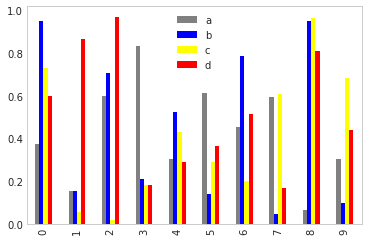

In [35]:
df.plot(kind='bar', color=['gray', 'blue', 'yellow', 'red'],  grid=False)

plt.show()

In [39]:
df

a         b         c         d
0  0.374540  0.950714  0.731994  0.598658
1  0.156019  0.155995  0.058084  0.866176
2  0.601115  0.708073  0.020584  0.969910
3  0.832443  0.212339  0.181825  0.183405
4  0.304242  0.524756  0.431945  0.291229
5  0.611853  0.139494  0.292145  0.366362
6  0.456070  0.785176  0.199674  0.514234
7  0.592415  0.046450  0.607545  0.170524
8  0.065052  0.948886  0.965632  0.808397
9  0.304614  0.097672  0.684233  0.440152

### 排列组合函数测试

In [ ]:
a =it.combinations(list(df_data.columns.drop('pred')),7)

In [ ]:
[i for i in a]

[('PID1', 'TRIM22', 'SDC2', 'PARP9', 'HIST1H3G', 'EPSTI1', 'U2AF1L4'),
 ('PID1', 'TRIM22', 'SDC2', 'PARP9', 'HIST1H3G', 'EPSTI1', 'DUSP2'),
 ('PID1', 'TRIM22', 'SDC2', 'PARP9', 'HIST1H3G', 'U2AF1L4', 'DUSP2'),
 ('PID1', 'TRIM22', 'SDC2', 'PARP9', 'EPSTI1', 'U2AF1L4', 'DUSP2'),
 ('PID1', 'TRIM22', 'SDC2', 'HIST1H3G', 'EPSTI1', 'U2AF1L4', 'DUSP2'),
 ('PID1', 'TRIM22', 'PARP9', 'HIST1H3G', 'EPSTI1', 'U2AF1L4', 'DUSP2'),
 ('PID1', 'SDC2', 'PARP9', 'HIST1H3G', 'EPSTI1', 'U2AF1L4', 'DUSP2'),
 ('TRIM22', 'SDC2', 'PARP9', 'HIST1H3G', 'EPSTI1', 'U2AF1L4', 'DUSP2')]

In [ ]:
list(df_data.columns.drop('pred'))

['PID1', 'TRIM22', 'SDC2', 'PARP9', 'HIST1H3G', 'EPSTI1', 'U2AF1L4', 'DUSP2']

In [ ]:
a = it.combinations('ABCD', 2)

In [ ]:
list(it.combinations(list(df_data.columns.drop('pred')),7))[0]

('PID1', 'TRIM22', 'SDC2', 'PARP9', 'HIST1H3G', 'EPSTI1', 'U2AF1L4')

In [ ]:
for e in it.combinations('ABCD', 1):
    print(e, end=', ')
    print(''.join(e), end=', ')

('A',), A, ('B',), B, ('C',), C, ('D',), D, 

In [ ]:
x = df_data[list(list(it.combinations(list(df_data.columns.drop('pred')),1))[0])]

### 卡方检验

In [181]:
from  scipy.stats import chi2_contingency
import numpy as np
kf_data = np.array([[37,27], [39,21]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=0.4054, p-value=0.5243, df=1 expected_frep=[[39.23 24.77]
 [36.77 23.23]]


In [184]:
from  scipy.stats import chi2_contingency
import numpy as np
kf_data = np.array([[11.7,8.7,15.4,8.4], [18.1,11.7,24.3,13.6],
              [26.9,20.3,37,19.3],[41,30.9,54.6,35.1],
              [66,54.3,71.1,50]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)


chisq-statistic=2.9208, p-value=0.9961, df=12 expected_frep=[[11.7   9.   14.47  9.03]
 [17.92 13.78 22.16 13.84]
 [27.4  21.07 33.88 21.16]
 [42.78 32.9  52.89 33.03]
 [63.9  49.15 79.01 49.34]]


In [186]:
import pandas as pd 
import numpy as np 
from scipy import stats
#创建上述表
observed_pd = pd.DataFrame(['1点']*23+['2点']*20+['3点']*18+['4点']*19+['5点']*24+['6点']*16)
expected_pd = pd.DataFrame(['1点']*20+['2点']*20+['3点']*20+['4点']*20+['5点']*20+['6点']*20)
observed_table = pd.crosstab(index=observed_pd[0],columns='count')
expected_table = pd.crosstab(index=expected_pd[0],columns='count')
print(observed_table)
print('——————')
print(expected_table)
#通过公式算出卡方值
observed = observed_table 
expected = expected_table 
chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat')
print(chi_squared_stat)

col_0  count
0           
1点        23
2点        20
3点        18
4点        19
5点        24
6点        16
——————
col_0  count
0           
1点        20
2点        20
3点        20
4点        20
5点        20
6点        20
chi_squared_stat
col_0
count    2.3
dtype: float64


In [197]:
a = pd.DataFrame(index = ['a','b'],columns = ['a','b','c'])

In [37]:
a = pd.DataFrame(np.random.randint(0,151,[100,3]),columns = ['python','r','math'])

In [536]:
[str(i) for i in pd.cut(a.iloc[:,1],[-1,30,60,100,151])]

['(-1, 30]',
 '(-1, 30]',
 '(100, 151]',
 '(100, 151]',
 '(100, 151]',
 '(60, 100]',
 '(100, 151]',
 '(-1, 30]',
 '(60, 100]',
 '(100, 151]',
 '(-1, 30]',
 '(30, 60]',
 '(60, 100]',
 '(-1, 30]',
 '(100, 151]',
 '(30, 60]',
 '(60, 100]',
 '(100, 151]',
 '(30, 60]',
 '(100, 151]',
 '(60, 100]',
 '(30, 60]',
 '(30, 60]',
 '(30, 60]',
 '(100, 151]',
 '(-1, 30]',
 '(30, 60]',
 '(-1, 30]',
 '(-1, 30]',
 '(30, 60]',
 '(100, 151]',
 '(100, 151]',
 '(100, 151]',
 '(-1, 30]',
 '(60, 100]',
 '(60, 100]',
 '(30, 60]',
 '(-1, 30]',
 '(100, 151]',
 '(100, 151]',
 '(60, 100]',
 '(60, 100]',
 '(60, 100]',
 '(60, 100]',
 '(100, 151]',
 '(60, 100]',
 '(60, 100]',
 '(100, 151]',
 '(30, 60]',
 '(100, 151]',
 '(-1, 30]',
 '(100, 151]',
 '(100, 151]',
 '(-1, 30]',
 '(100, 151]',
 '(60, 100]',
 '(30, 60]',
 '(100, 151]',
 '(60, 100]',
 '(60, 100]',
 '(60, 100]',
 '(100, 151]',
 '(100, 151]',
 '(60, 100]',
 '(30, 60]',
 '(100, 151]',
 '(60, 100]',
 '(100, 151]',
 '(30, 60]',
 '(-1, 30]',
 '(60, 100]',
 '(60, 

In [537]:
a.iloc[:,1] = [str(i) for i in pd.cut(a.iloc[:,1],[-1,30,60,100,151])]

In [538]:
a.to_csv('./a.csv')

In [555]:
b = pd.read_csv(f'{app.config["MATRIX_OUTPUT_PATH"]}/test2/clinical.csv',index_col = 0)

In [557]:
c = pd.crosstab(b['pred'],b['visit'])

In [559]:
stats.chi2_contingency(c)

(7.8546839651668785,
 0.09704870709278958,
 4,
 array([[306.38,  55.61,  21.51,   8.92, 129.58],
        [277.62,  50.39,  19.49,   8.08, 117.42]]))

In [45]:
a[['r']].iloc[:,0]

0      92
1      71
2     121
3     116
4     130
     ... 
95     53
96    103
97     31
98    126
99    103
Name: r, Length: 100, dtype: int64

### GridSearchCV & Pipline

In [16]:
df_train = pd.read_csv('./webApp/output_result/matrix/classification_test/df_train.csv',index_col=0)

In [17]:
df_test = pd.read_csv('./webApp/output_result/matrix/classification_test/df_test.csv',index_col=0)

In [563]:
features_slct,model,result,modelname,best_params = sel_f_model(df_train.drop('pred',axis=1).iloc[:,:1000],df_train['pred'],\
                                                   df_test.drop('pred',axis=1).iloc[:,:1000],df_test['pred'])

检查循环和训练集....
LogisticRegression
(450, 404)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
检查循环和训练集....
LinearSVC
(450, 395)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
检查循环和训练集....
RandomForest
(450, 329)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/users/machiyu/anaconda3/envs/Flask/lib/pyth

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
检查循环和训练集....
Lasso.1
(450, 4)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
检查循环和训练集....
LDA
(450, 399)
begin gridsearchcv-ModelType.LR


/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT


In [7]:
y_train = df_train.T['pred']
x_train = df_train.drop('pred').T

In [372]:
y_test = df_test.T['pred']
x_test = df_test.drop('pred').T

In [9]:
best_params, best_score, cv_results = HPO(np.array(x_train),np.array(y_train),param_config=param_config,classifier=LogisticRegression())

/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [10]:
best_params

{'C': 0.01,
 'l1_ratio': 0.3,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [11]:
best_score

0.6377777777777778

In [13]:
cv_results

{'mean_fit_time': array([ 0.67379928,  0.43462515,  2.22777152,  2.42068105,  0.65511994,
         0.79765186,  3.08259339,  3.53946638,  0.5152935 ,  0.33721442,
         2.64843779,  5.07603869,  0.57829027,  0.75561109,  3.64727111,
         6.35734529,  0.44071541,  0.35624475,  2.25797276,  2.43168759,
         0.73384557,  0.83986411,  3.11085048,  3.5011167 ,  0.48678455,
         0.44141188,  8.99086742, 11.98373246,  0.65802145,  0.9480279 ,
        11.22134967, 17.38229275,  0.43600464,  0.3331543 ,  2.22169538,
         2.39432387,  0.58962908,  0.837994  ,  3.11360474,  3.51648993,
         0.43886614,  0.50730066, 10.9804935 , 11.95804224,  0.63723507,
         1.23741941, 15.3939312 , 17.38564291,  0.49514399,  0.36433806,
         2.18406453,  2.41580749,  0.6122848 ,  0.76346555,  3.07132134,
         3.49518628,  0.45126953,  0.58729157, 10.94934874, 11.93505898,
         0.69096451,  1.0141417 , 15.5251132 , 17.51290898,  0.47097459,
         0.31901302,  2.21341209, 

In [12]:
classifier = LogisticRegression(
            penalty=best_params["penalty"],
            C=best_params["C"],
            multi_class=best_params["multi_class"],
            solver=best_params["solver"],
            max_iter=best_params["max_iter"],
            l1_ratio=best_params["l1_ratio"],
        )

In [13]:
classifier.fit(
        np.array(x_train),np.array(y_train)
    )

LogisticRegression(C=0.01, l1_ratio=0.3, multi_class='multinomial',
                   penalty='elasticnet', solver='saga')

In [14]:
# Assess the performance.
y_pred = classifier.predict(x_test)
performance = calculate_prediction_performance(y_test, y_pred, Metrics.Accuracy, Average.Micro)



In [18]:
scoring = get_scoring_str(Metrics.Accuracy, Average.Micro)
feature_names = x_train.columns.values.tolist()

In [19]:
# Permutation feature importance.
feature_importance = permutation_importance(
    classifier, x_test, y_test, n_jobs=8, scoring=scoring
).importances_mean
feature_importance_with_name = list(zip(feature_names, feature_importance))


In [22]:
display_attribute: bool = True
display_cv_results: bool = False

In [23]:
# Display classifer's attributes and cv results.
if display_attribute:
    display_classifier_attr(classifier, best_params)
if display_cv_results:
    print(
        "Cross-validated score of different parameter settings:",
        pd.DataFrame(cv_results),
    )

Best parameters selected: {'C': 0.01, 'l1_ratio': 0.3, 'max_iter': 100, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga'}
Coefficient: [[0. 0. 0. ... 0. 0. 0.]]
Bias: [-0.01592035]


In [414]:
selector = SelectFromModel(LogisticRegression())

In [415]:
classifier = RandomForestClassifier()

In [416]:
ml_pipeline = Pipeline([('select',selector),('pca',PCA()),('classifier',classifier)])

In [417]:
pipe_params={'classifier__max_depth': [3, 7],
  'select__estimator__penalty': ['l2'],
  'select__estimator__C': [0.01, 0.1, 1, 10],
  'select__estimator__multi_class': ['ovr'],
  'select__estimator__solver': [ 'lbfgs'],
  'select__estimator__max_iter': [100],
  'select__estimator__l1_ratio': [None]}

In [252]:
pipe_params=[{'select__threshold':[.01,.05,.1,'mean','median','2.*mean']}]

In [253]:
classifier_param_config = [{'classifier__max_depth':[1,3,5,7]}]

In [254]:
select_param_config = [dict([('select__estimator__'+i,j) for i,j in x.items()]) for x in param_config]

In [255]:
pipe_params = [{**i,**j,**k} for j in classifier_param_config for i in pipe_params for k in select_param_config]

In [260]:
pipe_params

[{'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'],
  'classifier__max_depth': [1, 3, 5, 7],
  'select__estimator__penalty': ['l2'],
  'select__estimator__C': [0.01, 0.1, 1, 10, 100],
  'select__estimator__multi_class': ['ovr', 'multinomial'],
  'select__estimator__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
  'select__estimator__max_iter': [100, 500],
  'select__estimator__l1_ratio': [None]},
 {'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'],
  'classifier__max_depth': [1, 3, 5, 7],
  'select__estimator__penalty': ['l1'],
  'select__estimator__C': [0.01, 0.1, 1, 10, 100],
  'select__estimator__multi_class': ['ovr'],
  'select__estimator__solver': ['liblinear', 'saga'],
  'select__estimator__max_iter': [100, 500],
  'select__estimator__l1_ratio': [None]},
 {'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'],
  'classifier__max_depth': [1, 3, 5, 7],
  'select__estimator__penalty': ['elasticnet'],
  'select__estimator__C': [0.01

In [404]:
get_best_model_and_accuracy(ml_pipeline,pipe_params,x_train,y_train)

(0.5177777777777778,
 {'classifier__max_depth': 3,
  'select__estimator__C': 1,
  'select__estimator__l1_ratio': None,
  'select__estimator__max_iter': 100,
  'select__estimator__multi_class': 'ovr',
  'select__estimator__penalty': 'l2',
  'select__estimator__solver': 'lbfgs'})

In [405]:
ml_pipeline.set_params(**{'classifier__max_depth': 3,
  'select__estimator__C': 1,
  'select__estimator__l1_ratio': None,
  'select__estimator__max_iter': 100,
  'select__estimator__multi_class': 'ovr',
  'select__estimator__penalty': 'l2',
  'select__estimator__solver': 'lbfgs'})

Pipeline(steps=[('select',
                 SelectFromModel(estimator=LogisticRegression(C=1,
                                                              multi_class='ovr'))),
                ('classifier', RandomForestClassifier(max_depth=3))])

In [408]:
ml_pipeline.steps[0][1].fit(x_train,y_train)

SelectFromModel(estimator=LogisticRegression(C=1, multi_class='ovr'))

In [409]:
feature = x_train.columns[ml_pipeline.steps[0][1].get_support()]

In [389]:
x_test_pca = PCA().fit_transform(x_test[feature])

In [411]:
ml_pipeline.steps[1][1].fit(x_train[feature],y_train)

RandomForestClassifier(max_depth=3)

In [412]:
ml_pipeline.steps[1][1].score(x_test[feature],y_test)

0.5066666666666667

In [418]:
get_best_model_and_accuracy(ml_pipeline,pipe_params,x_train,y_train)

(0.5511111111111111,
 {'classifier__max_depth': 3,
  'select__estimator__C': 0.01,
  'select__estimator__l1_ratio': None,
  'select__estimator__max_iter': 100,
  'select__estimator__multi_class': 'ovr',
  'select__estimator__penalty': 'l2',
  'select__estimator__solver': 'lbfgs'})

In [419]:
ml_pipeline.set_params(**{'classifier__max_depth': 3,
  'select__estimator__C': 0.01,
  'select__estimator__l1_ratio': None,
  'select__estimator__max_iter': 100,
  'select__estimator__multi_class': 'ovr',
  'select__estimator__penalty': 'l2',
  'select__estimator__solver': 'lbfgs'})

Pipeline(steps=[('select',
                 SelectFromModel(estimator=LogisticRegression(C=0.01,
                                                              multi_class='ovr'))),
                ('pca', PCA()),
                ('classifier', RandomForestClassifier(max_depth=3))])

In [420]:
ml_pipeline.steps[0][1].fit(x_train,y_train)

SelectFromModel(estimator=LogisticRegression(C=0.01, multi_class='ovr'))

In [421]:
feature = x_train.columns[ml_pipeline.steps[0][1].get_support()]

In [422]:
x_test_pca = PCA().fit_transform(x_test[feature])

In [423]:
x_train_pca = PCA().fit_transform(x_train[feature])

In [424]:
ml_pipeline.steps[2][1].fit(x_train_pca,y_train)

RandomForestClassifier(max_depth=3)

In [425]:
ml_pipeline.steps[2][1].score(x_test_pca,y_test)

ValueError: X has 150 features, but RandomForestClassifier is expecting 450 features as input.

In [426]:
feature

Index(['f1', 'f4', 'f6', 'f7', 'f12', 'f16', 'f18', 'f19', 'f20', 'f22',
       ...
       'f5972', 'f5979', 'f5982', 'f5983', 'f5985', 'f5986', 'f5992', 'f5995',
       'f5996', 'f5999'],
      dtype='object', length=2315)

### 方差过滤

In [42]:
var = VarianceThreshold(df_train.drop('pred',axis=1).var().mean())

In [47]:
dtrain_filt = var.fit_transform(df_train.drop('pred',axis=1))

In [54]:
var.fit(df_train.drop('pred',axis=1))

VarianceThreshold(threshold=1.2915612917739394)

In [61]:
var.get_feature_names_out()

array(['f5', 'f9', 'f13', ..., 'f5989', 'f5991', 'f5994'], dtype=object)

In [63]:
dtrain_filt  = pd.DataFrame(dtrain_filt)

In [65]:
dtrain_filt.columns = var.get_feature_names_out()

### 正则化

In [51]:
clf = LassoCV()

In [52]:
clf.fit(df_train.drop('pred',axis=1),df_train['pred'])

LassoCV()

In [59]:
clf.alpha_

0.06969219575465037

In [79]:
sel = SelectFromModel(RidgeCV())

In [80]:
sel.fit(df_train.drop('pred',axis=1),df_train['pred'])

SelectFromModel(estimator=RidgeCV())

In [81]:
df_train[sel.get_feature_names_out()].corr()

f1        f3        f4        f6        f7       f16       f18  \
f1     1.000000  0.058902 -0.006577 -0.021904 -0.070073  0.075099 -0.029592   
f3     0.058902  1.000000 -0.023070  0.051411  0.025265 -0.002170 -0.022869   
f4    -0.006577 -0.023070  1.000000  0.005372 -0.000004 -0.014978  0.006982   
f6    -0.021904  0.051411  0.005372  1.000000 -0.002180 -0.013451  0.004732   
f7    -0.070073  0.025265 -0.000004 -0.002180  1.000000  0.106571 -0.025717   
...         ...       ...       ...       ...       ...       ...       ...   
f5986  0.025349  0.007214  0.025480 -0.006104 -0.019345  0.029990 -0.006625   
f5992  0.015878 -0.041839 -0.093666 -0.065026 -0.041424 -0.000085 -0.000370   
f5995  0.004687  0.029608 -0.000661  0.046931 -0.018464  0.077756  0.029647   
f5996 -0.056133  0.053014 -0.011711  0.010649 -0.009171  0.018721  0.010117   
f5999  0.065770  0.041045  0.050981  0.056370 -0.054738  0.007658  0.038184   

            f19       f20       f22  ...     f5976     f5979     f5982  \
f1    -0.086677  0.035042  0.067320  ... -0.005427 -0.014049 -0.007634   
f3     0.066169 -0.016243  0.018946  ...  0.017708 -0.087552 -0.060713   
f4    -0.007805  0.018970  0.032863  ... -0.009476 -0.065648  0.016926   
f6     0.017400 -0.051443 -0.045833  ... -0.012827 -0.045994  0.036559   
f7     0.032020 -0.037301  0.011397  ... -0.052432  0.023524 -0.022081   
...         ...       ...       ...  ...       ...       ...       ...   
f5986 -0.019823  0.043979 -0.015947  ...  0.041108 -0.052029 -0.064723   
f5992 -0.035706  0.050269 -0.071687  ... -0.012893  0.003872  0.030593   
f5995  0.082984 -0.030009  0.060005  ... -0.060859 -0.048358 -0.082651   
f5996 -0.028417 -0.083203  0.003184  ...  0.041572 -0.018238 -0.020295   
f5999  0.038585 -0.033631  0.092692  ...  0.027031 -0.049183  0.068323   

          f5983     f5985     f5986     f5992     f5995     f5996     f5999  
f1    -0.101528  0.051633  0.025349  0.015878  0.004687 -0.056133  0.065770  
f3    -0.021927  0.004264  0.007214 -0.041839  0.029608  0.053014  0.041045  
f4     0.030091  0.007389  0.025480 -0.093666 -0.000661 -0.011711  0.050981  
f6    -0.034723  0.027889 -0.006104 -0.065026  0.046931  0.010649  0.056370  
f7    -0.022519  0.013327 -0.019345 -0.041424 -0.018464 -0.009171 -0.054738  
...         ...       ...       ...       ...       ...       ...       ...  
f5986 -0.022422 -0.054181  1.000000 -0.058866  0.011100 -0.137015  0.056706  
f5992  0.040425 -0.052006 -0.058866  1.000000 -0.000403  0.002927 -0.028148  
f5995  0.010069 -0.069813  0.011100 -0.000403  1.000000 -0.047107  0.060921  
f5996  0.062952  0.057356 -0.137015  0.002927 -0.047107  1.000000  0.007765  
f5999 -0.002586  0.009534  0.056706 -0.028148  0.060921  0.007765  1.000000  

[2345 rows x 2345 columns]

In [83]:
(abs(df_train[sel.get_feature_names_out()].corr()).sum().sum()-2345)/2345/2344

0.03765539928430137

In [68]:
df_cor = df_train.drop('pred',axis=1).corr()

In [74]:
(abs(df_cor).sum().sum()-6000)/6000/5999

0.09461083229466773

### 积因

In [3]:
feature_matrix, feature_to_type = generate_mock_feature_matrix()

In [ ]:
feature_matrix

f0        f1        f2         f3         f4        f5        f6  \
0    1.080536 -8.408984  0.568129  -2.391757  -2.275345 -4.165196 -7.968057   
1   -3.239246  8.143217 -3.718332  -6.844393   9.968023  4.393848 -7.916508   
2   -9.237147 -2.858642 -1.195995   9.022663   3.503404  2.888770 -7.134604   
3   -0.375643  6.518266 -1.795656  -5.960543  11.319392  3.258193 -8.112092   
4   -0.505564 -9.822353  0.149521  -2.676117  -3.390120 -4.268179 -6.840274   
..        ...       ...       ...        ...        ...       ...       ...   
145 -7.765629 -3.579018 -3.060889   9.601660   2.870398  3.403653 -5.950394   
146 -0.830075  5.947730 -1.637394  -5.961111  10.320933  4.377431 -8.028394   
147 -8.485569 -2.003314 -2.316636   8.417866   5.842730  2.987442 -5.794361   
148 -8.611581 -0.128412 -1.214810  10.646997   3.770350  4.658086 -7.593744   
149 -2.922825  7.737156 -0.821111  -6.239575   9.477924  3.935474 -7.109479   

           f7        f8         f9  ...      f441       f442       f443  \
0    1.421385 -3.963431  -5.243550  ...  3.403790  -4.580124   3.902289   
1    1.484339 -2.545304   8.200326  ...  7.303729  11.088064   2.064535   
2   -0.924918 -2.289267   8.581263  ... -4.328393  -0.921138  -8.978117   
3   -0.737244 -3.214278   7.653298  ...  7.302668   8.369059   2.280175   
4    2.294986 -2.908911  -4.652425  ...  3.775334  -2.832086   3.135467   
..        ...       ...        ...  ...       ...        ...        ...   
145 -0.679497 -2.012782  10.318231  ... -4.334796  -3.415173 -10.376179   
146  0.428675 -2.928874   8.483026  ...  4.316990   8.737364   1.459945   
147 -0.175916 -0.497147  10.591514  ... -5.975804  -3.799615  -9.356352   
148 -2.615017 -0.826069   9.145548  ... -3.747571  -4.473967 -11.454574   
149  0.963565 -3.992903   6.177303  ...  6.960117   8.754550   1.626527   

         f444       f445      f446      f447      f448      f449  label  
0    2.341279  -6.179941 -0.008182 -1.623168 -2.742775  5.149960      0  
1    4.355976   6.784887 -4.478592  3.573578  0.234675  8.143609      2  
2    0.534720 -11.678114 -4.570031  8.439600 -8.415009 -0.018920      1  
3    4.892988   7.772901 -4.340502  3.303499  0.890269  7.457757      2  
4   -2.133128  -5.668585  2.497760 -0.696179 -4.235353  4.912484      0  
..        ...        ...       ...       ...       ...       ...    ...  
145  0.326959 -10.307478 -4.169470  7.498828 -6.101160  1.462491      1  
146  3.054253   7.751832 -5.574637  2.566008 -1.338535  8.681039      2  
147  1.731013 -10.359485 -2.570768  8.259870 -7.743520  4.006313      1  
148  0.160592  -7.684616 -4.755324  8.672656 -6.109736  4.071106      1  
149  4.266993   6.295941 -5.735167  1.063284  2.592216  8.455708      2  

[150 rows x 451 columns]

In [5]:
feature_to_type

{'f0': 't0',
 'f1': 't0',
 'f2': 't0',
 'f3': 't0',
 'f4': 't0',
 'f5': 't0',
 'f6': 't0',
 'f7': 't0',
 'f8': 't0',
 'f9': 't0',
 'f10': 't0',
 'f11': 't0',
 'f12': 't0',
 'f13': 't0',
 'f14': 't0',
 'f15': 't0',
 'f16': 't0',
 'f17': 't0',
 'f18': 't0',
 'f19': 't0',
 'f20': 't0',
 'f21': 't0',
 'f22': 't0',
 'f23': 't0',
 'f24': 't0',
 'f25': 't0',
 'f26': 't0',
 'f27': 't0',
 'f28': 't0',
 'f29': 't0',
 'f30': 't0',
 'f31': 't0',
 'f32': 't0',
 'f33': 't0',
 'f34': 't0',
 'f35': 't0',
 'f36': 't0',
 'f37': 't0',
 'f38': 't0',
 'f39': 't0',
 'f40': 't0',
 'f41': 't0',
 'f42': 't0',
 'f43': 't0',
 'f44': 't0',
 'f45': 't0',
 'f46': 't0',
 'f47': 't0',
 'f48': 't0',
 'f49': 't0',
 'f50': 't0',
 'f51': 't0',
 'f52': 't0',
 'f53': 't0',
 'f54': 't0',
 'f55': 't0',
 'f56': 't0',
 'f57': 't0',
 'f58': 't0',
 'f59': 't0',
 'f60': 't0',
 'f61': 't0',
 'f62': 't0',
 'f63': 't0',
 'f64': 't0',
 'f65': 't0',
 'f66': 't0',
 'f67': 't0',
 'f68': 't0',
 'f69': 't0',
 'f70': 't0',
 'f71': 't0',
 '

In [20]:
feature_types_combinations = get_feature_type_combination(list(set(feature_to_type.values())))

In [21]:
feature_types_combinations

[('t1',),
 ('t2',),
 ('t0',),
 ('t1', 't2'),
 ('t1', 't0'),
 ('t2', 't0'),
 ('t1', 't2', 't0')]

In [23]:
feature_type_importance = calculate_feature_type_importance(feature_matrix,feature_to_type)

Best parameters selected: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Support vectors: [[ -2.11703441  -9.88893179   0.68718044 ...  -2.04223279  -2.11575917
    3.13494544]
 [ -0.86652732 -10.23794555   0.60632108 ...  -1.17785425  -3.94522052
    4.64002335]
 [ -1.22809888 -10.65944816   0.96711905 ...  -1.30600728  -2.22878019
    4.47102698]
 ...
 [ -1.07711755   7.31189332  -0.92753241 ...   2.08890074   0.86984554
    8.60269383]
 [ -0.14318649   8.29635021  -0.05852281 ...   1.13080391   0.58031153
    8.12518718]
 [ -0.29954275   8.76484387  -0.82186079 ...   1.78499162   2.0061885
    6.59592089]]
Best parameters selected: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Support vectors: [[ -2.14797706  -9.05542728   0.83349774 ...  -0.9067272   -4.02792462
    2.81050811]
 [ -0.86652732 -10.23794555   0.60632108 ...  -1.17785425  -3.94522052
    4.64002335]
 [ -1.22809888 -10.65944816   0.96711905 ...  -1.30600728  -2.22878019
    4.47102698]
 ...
 [ -1.76286822   9.27715821

In [24]:
feature_type_importance

[('t1', 0.0), ('t2', 0.0), ('t0', 0.0)]

In [25]:
best_feature_types_combination, best_performance = select_best_feature_type_combination(feature_matrix,feature_to_type)

Best parameters selected: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Support vectors: [[ 4.3956364  -8.19701508  7.71292823 ... -4.81031671  7.33923151
   4.23101194]
 [ 3.73180781 -7.09464345  5.87060015 ... -5.5785529   6.51223659
   5.12243074]
 [ 5.0293931  -8.09333581  7.38106689 ... -2.70012028  6.22460497
   2.14428408]
 ...
 [ 3.27307123  1.72780065 -7.8963498  ...  4.19002267 10.23837127
  -4.50717545]
 [ 3.00215547  0.45615441 -7.03839721 ...  4.66617745 10.90475855
  -6.51389371]
 [ 1.84741201  0.90458702 -6.00431667 ...  4.55963869  9.1034776
  -4.33983025]]
Best parameters selected: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Support vectors: [[-8.8258072   7.13435371  0.07639254 ... -2.04223279 -2.11575917
   3.13494544]
 [-7.74712327  7.97773956 -1.7130905  ... -1.17785425 -3.94522052
   4.64002335]
 [-7.67262738  6.1730592   0.20094202 ... -1.30600728 -2.22878019
   4.47102698]
 ...
 [ 6.40272873 -4.94691627  7.69892094 ...  2.39236275  1.7488579
   7.06737437]
 

In [26]:
best_feature_types_combination

('t1',)

In [27]:
best_performance

1.0

### Lasso调参

In [86]:
X_train , X_test, y_train, y_test = train_test_split( 
    df_train.drop('pred',axis=1), df_train['pred'], test_size=100, random_state=24)

In [87]:
poly = PolynomialFeatures( 
    degree = 2, include_bias = False, interaction_only = False)

NameError: name 'PolynomialFeatures' is not defined

In [ ]:
X_train_poly = poly.fit_transform(X_train) 
polynomial_column_names = \ 
    poly.get_feature_names(input_features = X_train.columns) 
X_train_poly = \ 
    pd.DataFrame(data = X_train_poly,  
        columns = polynomial_column_names ) 
 
X_train_poly.columns = X_train_poly.columns.str.replace(' ', '_') 
X_train_poly.columns = X_train_poly.columns.str.replace('^', '_')

In [89]:
sc = StandardScaler() 
 
X_train_poly_scaled = sc.fit_transform(X_train) 
X_train_poly_scaled = pd.DataFrame(data = X_train_poly_scaled, columns = X_train.columns)

In [111]:

X_test_poly_scaled = sc.transform(X_test)
X_test_poly_scaled = pd.DataFrame(data = X_test_poly_scaled, columns = X_test.columns)

In [128]:
def regmodel_param_plot( 
    validation_score, train_score, alphas_to_try, chosen_alpha, 
    scoring, model_name, test_score = None, filename = None): 
 
    plt.figure(figsize = (8,8)) 
    sns.lineplot(y = validation_score, x = alphas_to_try,  
                 label = 'validation_data') 
    sns.lineplot(y = train_score, x = alphas_to_try,  
                 label = 'training_data') 
    plt.axvline(x=chosen_alpha, linestyle='--') 
    if test_score is not None: 
        sns.lineplot(y = test_score, x = alphas_to_try,  
                     label = 'test_data') 
    plt.xlabel('alpha_parameter') 
    plt.ylabel(scoring) 
    plt.title(model_name + ' Regularisation') 
    plt.legend() 
    if filename is not None: 
        plt.savefig(str(filename) + ".png") 
    plt.show()

In [130]:
def regmodel_param_test( 
    alphas_to_try, X, y, cv, scoring = 'r2',  
    model_name = 'LASSO', X_test = None, y_test = None,  
    draw_plot = False, filename = None): 
 
    validation_scores = [] 
    train_scores = [] 
    results_list = [] 
    if X_test is not None: 
        test_scores = [] 
        scorer = get_scorer(scoring) 
    else: 
        test_scores = None 
 
    for curr_alpha in alphas_to_try: 
 
        if model_name == 'LASSO': 
            regmodel = Lasso(alpha = curr_alpha) 
        elif model_name == 'Ridge': 
            regmodel = Ridge(alpha = curr_alpha) 
        else: 
            return None 
 
        results = cross_validate( 
            regmodel, X, y, scoring=scoring, cv=cv,  
            return_train_score = True) 
 
        validation_scores.append(np.mean(results['test_score'])) 
        train_scores.append(np.mean(results['train_score'])) 
        results_list.append(results) 
 
        if X_test is not None: 
            regmodel.fit(X,y) 
            y_pred = regmodel.predict(X_test) 
            test_scores.append(scorer(regmodel, X_test, y_test)) 
 
    chosen_alpha_id = np.argmax(validation_scores) 
    chosen_alpha = alphas_to_try[chosen_alpha_id] 
    max_validation_score = np.max(validation_scores) 
    if X_test is not None: 
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id] 
    else: 
        test_score_at_chosen_alpha = None 
 
    if draw_plot: 
        regmodel_param_plot( 
            validation_scores, train_scores, alphas_to_try, chosen_alpha,  
            scoring, model_name, test_scores, filename) 
 
    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha

In [142]:
scorer = get_scorer('r2') 
scorer(Lasso(), X_test, y_test)

TypeError: ElasticNet.fit() missing 2 required positional arguments: 'X' and 'y'

In [143]:
lasso_alphas = np.linspace(0, 0.02, 11)

In [149]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = regmodel_param_test( 
        lasso_alphas, X_train_poly_scaled, y_train,  
        cv, scoring = 'r2', model_name = 'LASSO',  
        X_test = X_test_poly_scaled, y_test = y_test,  
        draw_plot = True, filename = 'lasso_wide_search') 
print("Chosen alpha: %.5f" % chosen_alpha) 
print("Validation score: %.5f" % max_validation_score) 
print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)

NameError: name 'cv' is not defined

In [150]:
lasso_alphas = np.linspace(0, 0.002, 11)

In [ ]:
LogisticRegression()

### 给旭哥


In [ ]:
def matrix_analysis(matrix_file, director,predclass, con, testP=0.25, imputeNA=1, filt_outlier=1):
    
    # 划分训练集测试集
    df_raw = matrix_file
    if isinstance(df_raw.iloc[0,0],str):
        df_raw.index = df_raw.iloc[:,0]
        df_raw = df_raw.iloc[:,1:]
    df_train = pd.concat([df_raw[df_raw[predclass]==list(set(df_raw[predclass]))[0]].sample(frac=.75),\
                      df_raw[df_raw[predclass]==list(set(df_raw[predclass]))[1]].sample(frac=.75)])
    df_test = pd.concat([df_raw,df_train]).drop_duplicates(keep=False)
    # df_train.to_csv(path_or_buf=f'{director}/df_train.csv')
    # df_test.to_csv(path_or_buf=f'{director}/df_test.csv')
    df_train = data_preprocess(df_train, predclass, con, imputeNA=1, filt_outlier=1)
    df_test = data_preprocess(df_test, predclass, con, imputeNA=1, filt_outlier=1)
    ###特征选择
    while True:
        try:
            con = int(con)
            disease = list(set(df_train[predclass]))
            disease.remove(con)
            disease = disease[0]
            break
        except ValueError:
            disease = list(set(df_train[predclass]))
            disease.remove(con)
            disease = disease[0]
            df_train[predclass] = [0 if x == con else 1 for x in df_train[predclass]]
            df_test[predclass] = [0 if x == con else 1 for x in df_test[predclass]]
            break

    x_train,x_test = df_train.drop(predclass,axis=1),df_test.drop(predclass,axis=1)
    y_train,y_test = df_train[predclass],df_test[predclass]
    
    # x_train[:] = preprocess(x_train.values,scale_by_minmax=True)
    # x_test[:] = preprocess(x_test.values,scale_by_minmax=True)
    # x_train = var_filter(0.1,x_train)
    # x_test = x_test[x_train.columns]
    # x_train[:] = preprocess(x_train.values,scale_by_minmax=False)
    # x_test[:] = preprocess(x_test.values,scale_by_minmax=False)
    
    ##wrapper
    # df_dat = Recursive_Feature_Elimination(df_train, predclass)
    # features_slct = list(df_dat.columns.drop(predclass))
    # df_dat[predclass] = [0 if x == con else 1 for x in df_dat[predclass]]
    ##SelectFromModel
    features_slct,model,result,modelname,best_params,model_probs = sel_f_model(x_train,y_train,x_test,y_test)
    output = {}
    features_importance = {}
    for i in result.columns:
        output[i] = {result.loc[result.index[:-1],i].astype('float').idxmax():result\
                     .loc[result.index[:-1],i].astype('float').max(),'features':result.loc[result.index[-1],i]}
        if isinstance(result.loc[result.index[-1],'Lasso.1'],str):
            df_dat = df_train[result.loc[result.index[-1],i].split(';')+[predclass]]
            features_importance[i] = Plot_feature_importance(df_dat, predclass, ax=axes[0])
        #     result.to_csv(path_or_buf=f'{director}/feature_slct.csv')
#     best_params.to_csv(path_or_buf=f'{director}/best_params.csv')
#     df_dat = df_train[features_slct+[predclass]]

#     x_train, x_test = df_train[features_slct],df_test[features_slct]
#     y_train,y_test = df_train[predclass],df_test[predclass]
    
#     trainauc = {}
#     testauc = {}
#     for x in df_train.columns.drop(predclass):
#         train_evaluate = Biomarker_Evaluate(df_train[predclass],df_train[x].astype('float'))
#         test_evaluate = Biomarker_Evaluate(df_test[predclass],df_test[x].astype('float'))
        
#         trainpred_roc,trainpred_pr,trainauc[x] = train_evaluate.evaluate()
#         testpred_roc,testpred_pr,testauc[x] = test_evaluate.evaluate()
    
#     trainroc = pd.DataFrame(trainauc).T
#     testroc = pd.DataFrame(testauc).T
#     df_roc = pd.concat([trainroc,testroc],axis =1,keys=['train','test'])
#     df_roc.to_csv(path_or_buf=f'{director}/df_roc.csv')
    
    return output,feature_importance

df_dat, X_train, X_test, y_train, y_test,model,modelname,disease,model_probs = matrix_analysis\
    (dat_file, director,predclass, con, testP=0.25, 
     imputeNA=1, filt_outlier=1)

    fig = Figure(figsize=(16,32),dpi=600)
    axes = fig.subplots(nrows=1, ncols=2)
    #missingno.matrix(df_dat, figsize = (30,5), ax=axes[0])

    features_importance = Plot_feature_importance(df_dat, predclass, ax=axes[0])
    features_importance.to_csv(path_or_buf=f'{director}/features_importance.csv')

    # selection model
    model_evaluate = {}
    
    md_test = Biomarker_Evaluate(y_test,model_probs[modelname])
    pred_roc,pred_pr,model_evaluate[modelname.value] = md_test.evaluate()
    roc_confusion_matrix = md_test.confusion_matrix_(pred_roc)
    pr_confusion_matrix = md_test.confusion_matrix_(pred_pr)
    roc_confusion_matrix.to_csv(path_or_buf = f'{director}/{modelname.value}_roc_confusion_matrix.csv')
    pr_confusion_matrix.to_csv(path_or_buf = f'{director}/{modelname.value}_pr_confusion_matrix.csv')
    model_evaluate = pd.DataFrame(model_evaluate).T
    model_evaluate.to_csv(path_or_buf = f'{director}/model_evaluate.csv')
    md_test.plot_roc(f'{director}/{modelname.value}_roc_plot.png')
    md_test.plot_prroc(f'{director}/{modelname.value}_pr_plot.png')
    md_test.plot_confusion_matrix(pred_roc,[con,disease],f'{director}/{modelname.value}_roc_confusion_matrix.png')
    md_test.plot_confusion_matrix(pred_pr,[con,disease],f'{director}/{modelname.value}_pr_confusion_matrix.png')
    
    Plot_ROC_Curves_Web([i.value for i in list(model_probs.keys())], list(model_probs.values()), y_test, ax=axes[1])
    

In [1]:
a = {'a':1,'b':2}

In [13]:
result = pd.read_csv('output_result/gene/GSE6613_parkinson_vs_healthy/feature_slct.csv',index_col=0)

In [72]:
output = {}
features_importance = {}
for i in result.columns:
    output[i] = {result.loc[result.index[:-1],i].astype('float').idxmax():result\
                 .loc[result.index[:-1],i].astype('float').max(),'features':result.loc[result.index[-1],i]}
    if isinstance(result.loc[result.index[-1],'Lasso.1'],str):
        df_dat = df_train[result.loc[result.index[-1],i].split(';')+[predclass]]
        features_importance[i] = Plot_feature_importance(df_dat, predclass, ax=axes[0])

NameError: name 'df_train' is not defined

In [97]:
result.loc[result.index[-1],'Lasso.1']

'KRT81;KLKB1;MYF6;NTN1;MYF5;ETV2;KRT20;ZMYM1;PTPN13;CKM;POLD4;PEX13;RBM41;PURG;NSUN6;ZBTB33;ERF;COL4A5;PTH1R;SLC15A3;IFT57;WDR41;RPS4Y1;BCMO1'

In [100]:
isinstance(result.loc[result.index[-1],'Lasso.1'],str)

True

In [70]:
output

{'LogisticRegression': {'LogisticRegression': 0.5,
  'features': 'KLKB1;MYF6;NTN1;MYF5;ETV2;KRT20;ZMYM1;PTPN13;CRLF1;PEX13;MLLT4-AS1;HIST1H3B;LRRC31;ACN9;NSUN6;ZBTB33;COL4A5;EEA1;IL26;SLC38A4;SPP1;OR1G1;BRIP1;CENPM;CACNG5;IFT22;NACAD;HMGN5;CA8;CNTN5;IFT57;NPPB;LBP;CRIPT;PRKAA2;TXLNA;WDR41;PTTG3P;CCK;EREG;RPS4Y1;NDUFAF7;ALLC;BCMO1;PTOV1;CLIC2;KRT35;SRY;PCDHGA9;CRYAA;FUZ'},
 'LinearSVC': {'KNN': 0.5902777777777778,
  'features': 'KLKB1;MYF6;NTN1;MYF5;ETV2;KRT20;PTPN13;CRLF1;PEX13;HIST1H3B;LRRC31;ACN9;ZBTB33;COL4A5;EEA1;IL26;FOXM1;SLC38A4;SPP1;OR1G1;BRIP1;CENPM;CACNG5;IFT22;NACAD;HMGN5;CA8;SCN3A;IFT57;NPPB;PRKAA2;TXLNA;WDR41;PTTG3P;CCK;EREG;RPS4Y1;NDUFAF7;ALLC;PTOV1;GRIP1;CLIC2;KRT35;SRY;PCDHGA9;CRYAA;FUZ'},
 'RandomForest': {'GradientBoosting': 0.4861111111111112,
  'features': 'KRT81;KLKB1;MYF6;NTN1;MYF5;ETV2;KRT20;ZMYM1;PTPN13;CRLF1;CKM;PEX13;MLLT4-AS1;AHSG;LRRC31;ACN9;NSUN6;ZBTB33;COL4A5;IL26;HOXC8;FOXM1;OR1G1;BRIP1;CENPM;CACNG5;KLRC4;NACAD;USP9Y;HMGN5;CA8;TCHH;NPPB;SOAT2;PRKAA2;CCL7;

In [16]:
result

LogisticRegression  \
LogisticRegression                                                        0.5   
KNN                                                        0.3194444444444444   
RandomForest                                                           0.4375   
GradientBoosting                                          0.38888888888888895   
LinearDiscriminantAnalysis                                 0.3333333333333333   
features                    KLKB1;MYF6;NTN1;MYF5;ETV2;KRT20;ZMYM1;PTPN13;C...   

                                                                    LinearSVC  \
LogisticRegression                                                        0.5   
KNN                                                        0.5902777777777778   
RandomForest                                               0.3402777777777778   
GradientBoosting                                           0.5277777777777778   
LinearDiscriminantAnalysis                                 0.3402777777777778   
features                    KLKB1;MYF6;NTN1;MYF5;ETV2;KRT20;PTPN13;CRLF1;P...   

                                                                 RandomForest  \
LogisticRegression                                         0.2777777777777778   
KNN                                                        0.2569444444444444   
RandomForest                                              0.45138888888888884   
GradientBoosting                                           0.4861111111111112   
LinearDiscriminantAnalysis                                 0.3819444444444444   
features                    KRT81;KLKB1;MYF6;NTN1;MYF5;ETV2;KRT20;ZMYM1;PT...   

                                                                          LDA  \
LogisticRegression                                         0.5555555555555556   
KNN                                                        0.4444444444444444   
RandomForest                                                              0.5   
GradientBoosting                                           0.5416666666666666   
LinearDiscriminantAnalysis                                 0.5069444444444444   
features                    KLKB1;NTN1;KRT20;ZMYM1;PTPN13;CRLF1;CKM;IFI27;...   

                                                                      LassoCV  \
LogisticRegression                                         0.7083333333333334   
KNN                                                        0.6597222222222223   
RandomForest                                               0.6111111111111112   
GradientBoosting                                           0.5555555555555556   
LinearDiscriminantAnalysis                                 0.4861111111111111   
features                    KLKB1;MYF6;MYF5;ETV2;BMX;KRT20;FKBP9;ZMYM1;PTP...   

                                                                      RidgeCV  \
LogisticRegression                                         0.5833333333333335   
KNN                                                        0.5347222222222222   
RandomForest                                               0.4652777777777778   
GradientBoosting                                           0.4722222222222222   
LinearDiscriminantAnalysis                                 0.4722222222222222   
features                    KRT81;KLKB1;MYF6;NTN1;MYF5;ETV2;KRT20;PTPN13;C...   

                            Lasso1  \
LogisticRegression             NaN   
KNN                            NaN   
RandomForest                   NaN   
GradientBoosting               NaN   
LinearDiscriminantAnalysis     NaN   
features                       NaN   

                                                                      Lasso.1  
LogisticRegression                                         0.4305555555555556  
KNN                                                        0.3333333333333333  
RandomForest                                               0.2777777777777778  
GradientBoosting                                          0.2083

In [32]:
result.loc[result.index[:-1],i]

LogisticRegression                            0.5
KNN                            0.3194444444444444
RandomForest                               0.4375
GradientBoosting              0.38888888888888895
LinearDiscriminantAnalysis     0.3333333333333333
Name: LogisticRegression, dtype: object

In [61]:
result.loc[result.index[:-1],i].astype('float').max()

0.5

In [60]:
result.loc[result.index[:-1],i].astype('float').idxmax()

'LogisticRegression'

In [54]:
result.dtypes


LogisticRegression     object
LinearSVC              object
RandomForest           object
LDA                    object
LassoCV                object
RidgeCV                object
Lasso1                float64
Lasso.1                object
dtype: object

In [63]:
result.loc[result.index[-1],i].split(';')

['KLKB1',
 'MYF6',
 'NTN1',
 'MYF5',
 'ETV2',
 'KRT20',
 'ZMYM1',
 'PTPN13',
 'CRLF1',
 'PEX13',
 'MLLT4-AS1',
 'HIST1H3B',
 'LRRC31',
 'ACN9',
 'NSUN6',
 'ZBTB33',
 'COL4A5',
 'EEA1',
 'IL26',
 'SLC38A4',
 'SPP1',
 'OR1G1',
 'BRIP1',
 'CENPM',
 'CACNG5',
 'IFT22',
 'NACAD',
 'HMGN5',
 'CA8',
 'CNTN5',
 'IFT57',
 'NPPB',
 'LBP',
 'CRIPT',
 'PRKAA2',
 'TXLNA',
 'WDR41',
 'PTTG3P',
 'CCK',
 'EREG',
 'RPS4Y1',
 'NDUFAF7',
 'ALLC',
 'BCMO1',
 'PTOV1',
 'CLIC2',
 'KRT35',
 'SRY',
 'PCDHGA9',
 'CRYAA',
 'FUZ']

In [129]:
cs = pd.read_excel('con-sepsis.xlsx',index_col=0)

In [130]:
ns = pd.read_excel('sepsis-nonsepsis.xlsx',index_col=0)

In [131]:
cs.iloc[4,:] = [0 if i == 'con' else 1 for i in cs.iloc[4,:]]

In [132]:
ns.iloc[4,:] = [0 if i == 'Non_Sepsis' else 1 for i in ns.iloc[4,:]]

In [148]:
cs = cs.T

In [150]:
ns = ns.T

In [163]:
cs = cs.astype('float64')

In [164]:
ns = ns.astype('float64')

In [173]:
crp = Biomarker_Evaluate(cs['pred'],cs['CRP'])

In [174]:
pred_roc,pred_pr,crp_evaluate = crp.evaluate()

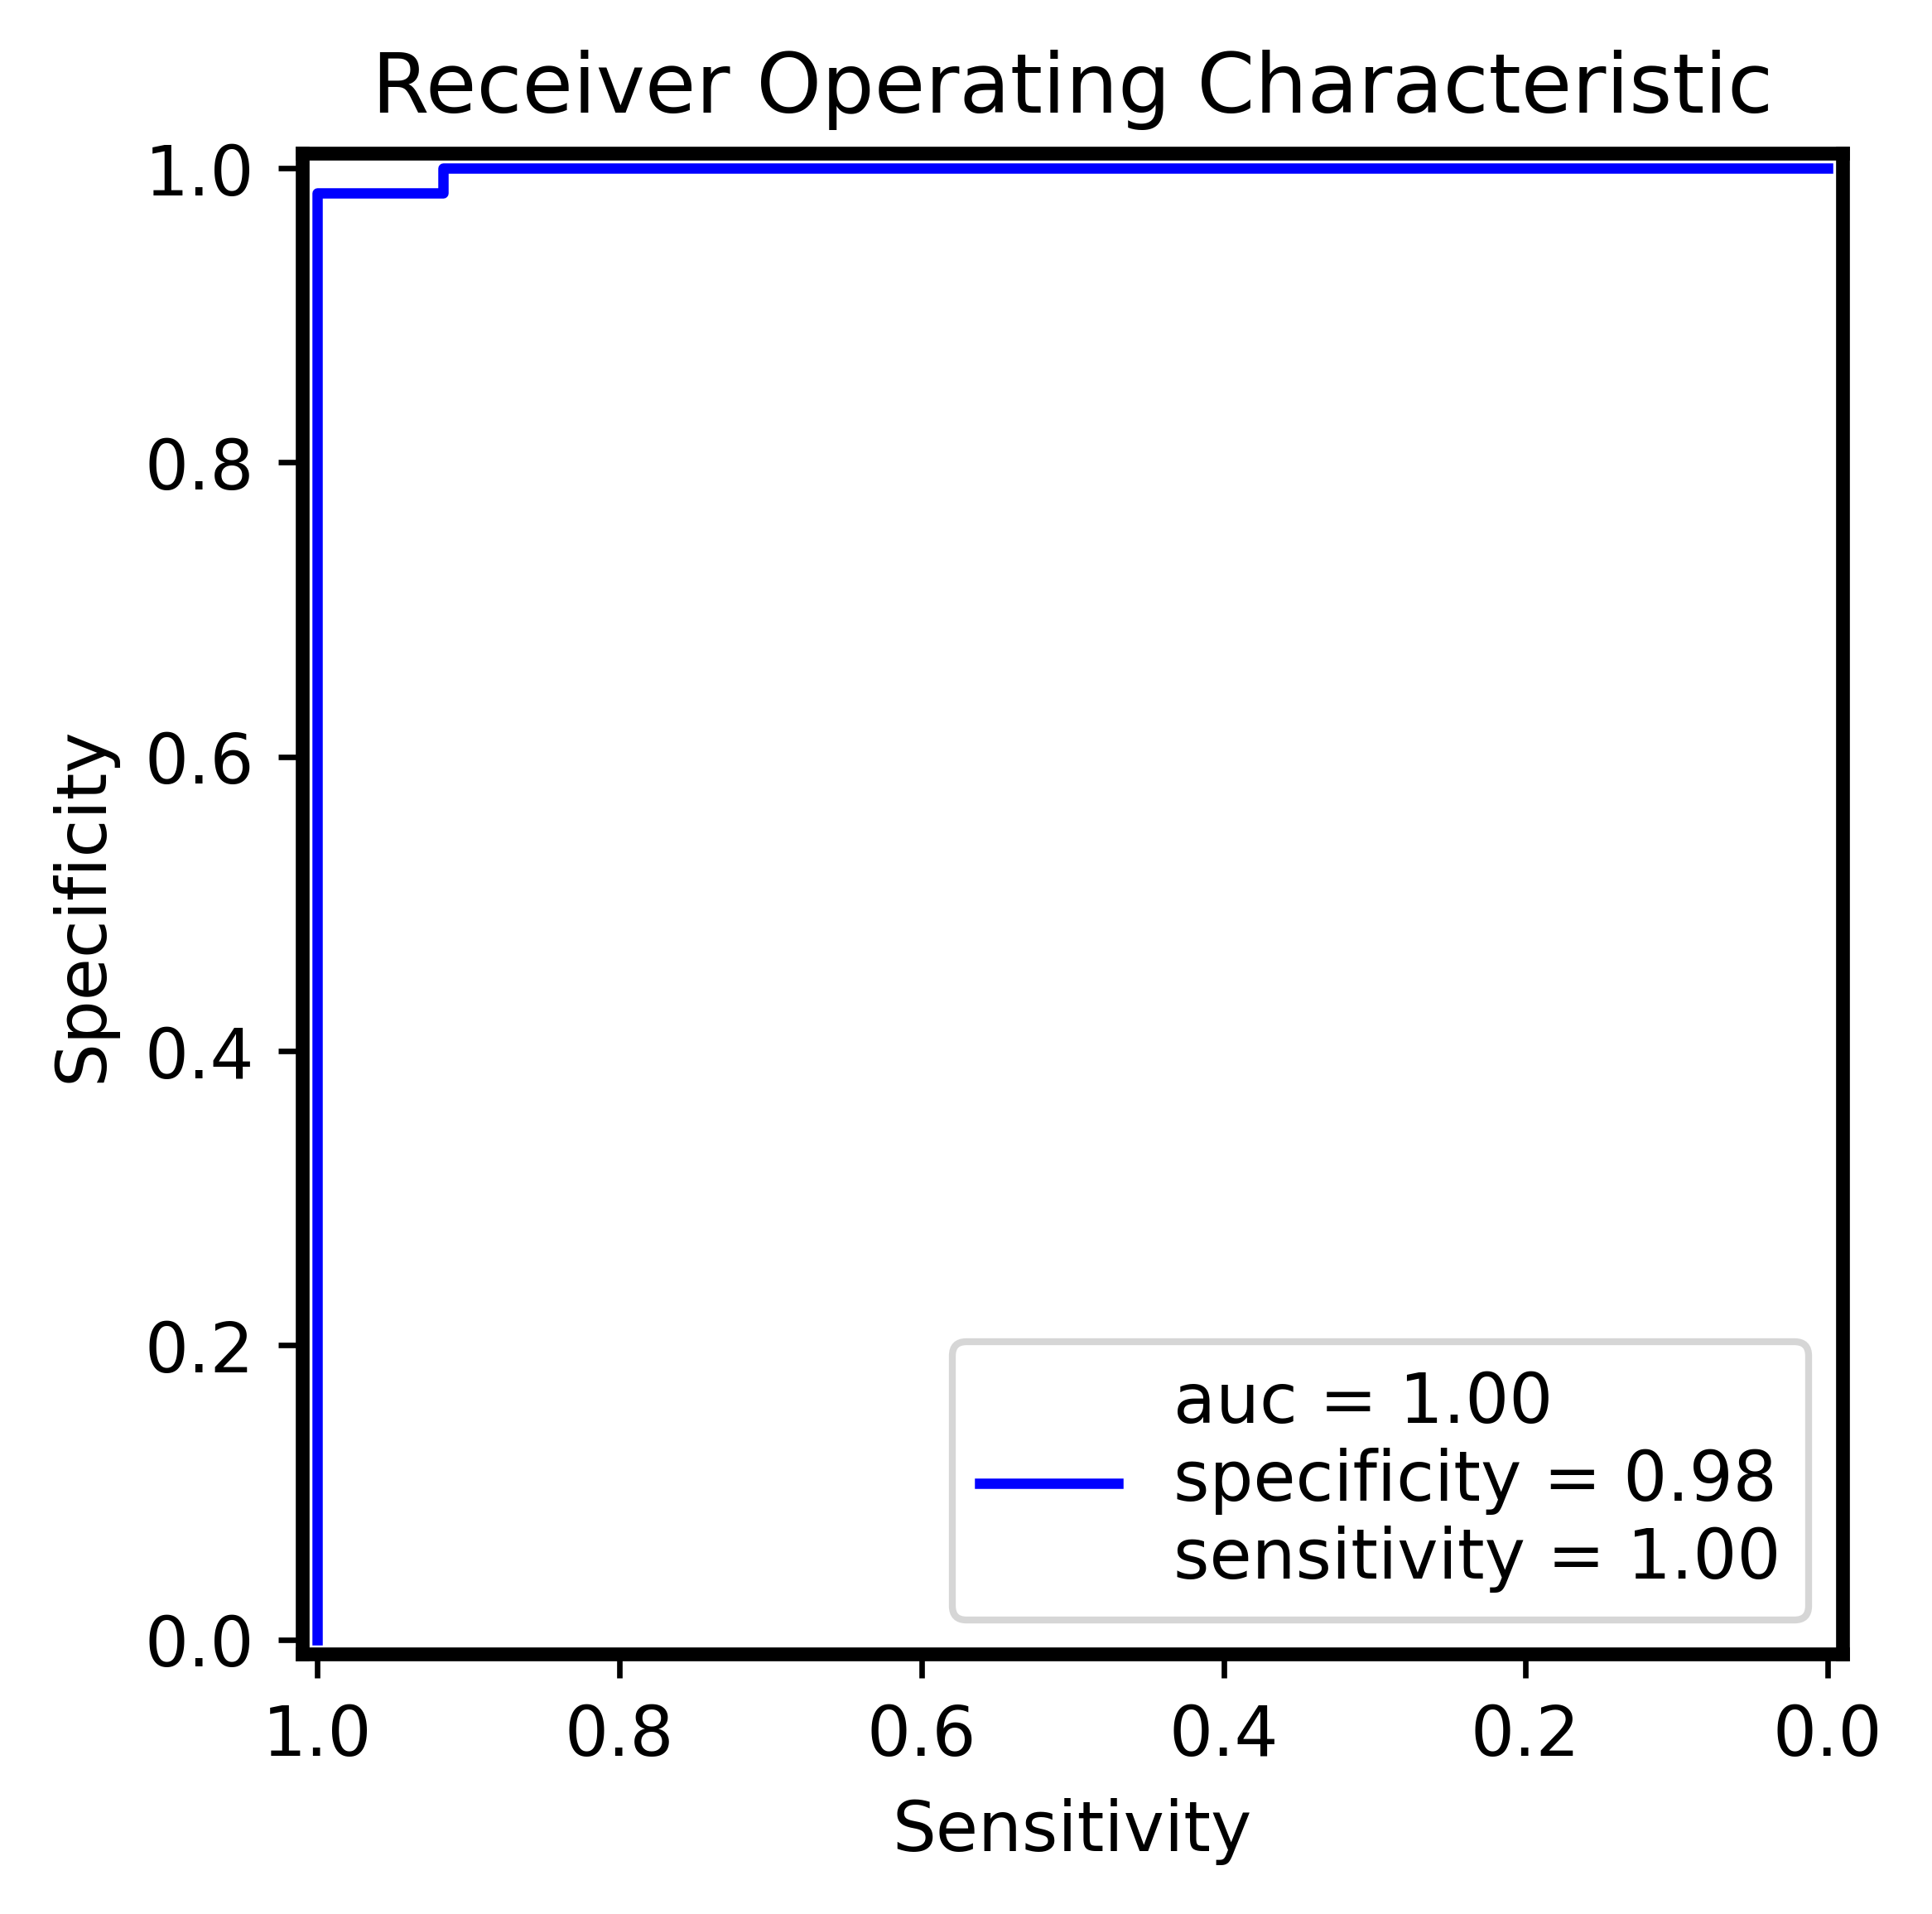

In [175]:
crp.plot_roc('crp_roc.png')

In [201]:
models = {ModelType.DT: DecisionTreeClassifier()}
model_scores, model_probs, best_params = fit_and_score(ns[['CRP','PSP']], ns[['CRP','PSP']], ns['pred'], ns['pred'], models)


begin gridsearchcv-ModelType.DT
finish gridsearchcv-ModelType.DT


In [205]:
best_params

[{'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'splitter': 'random'}]

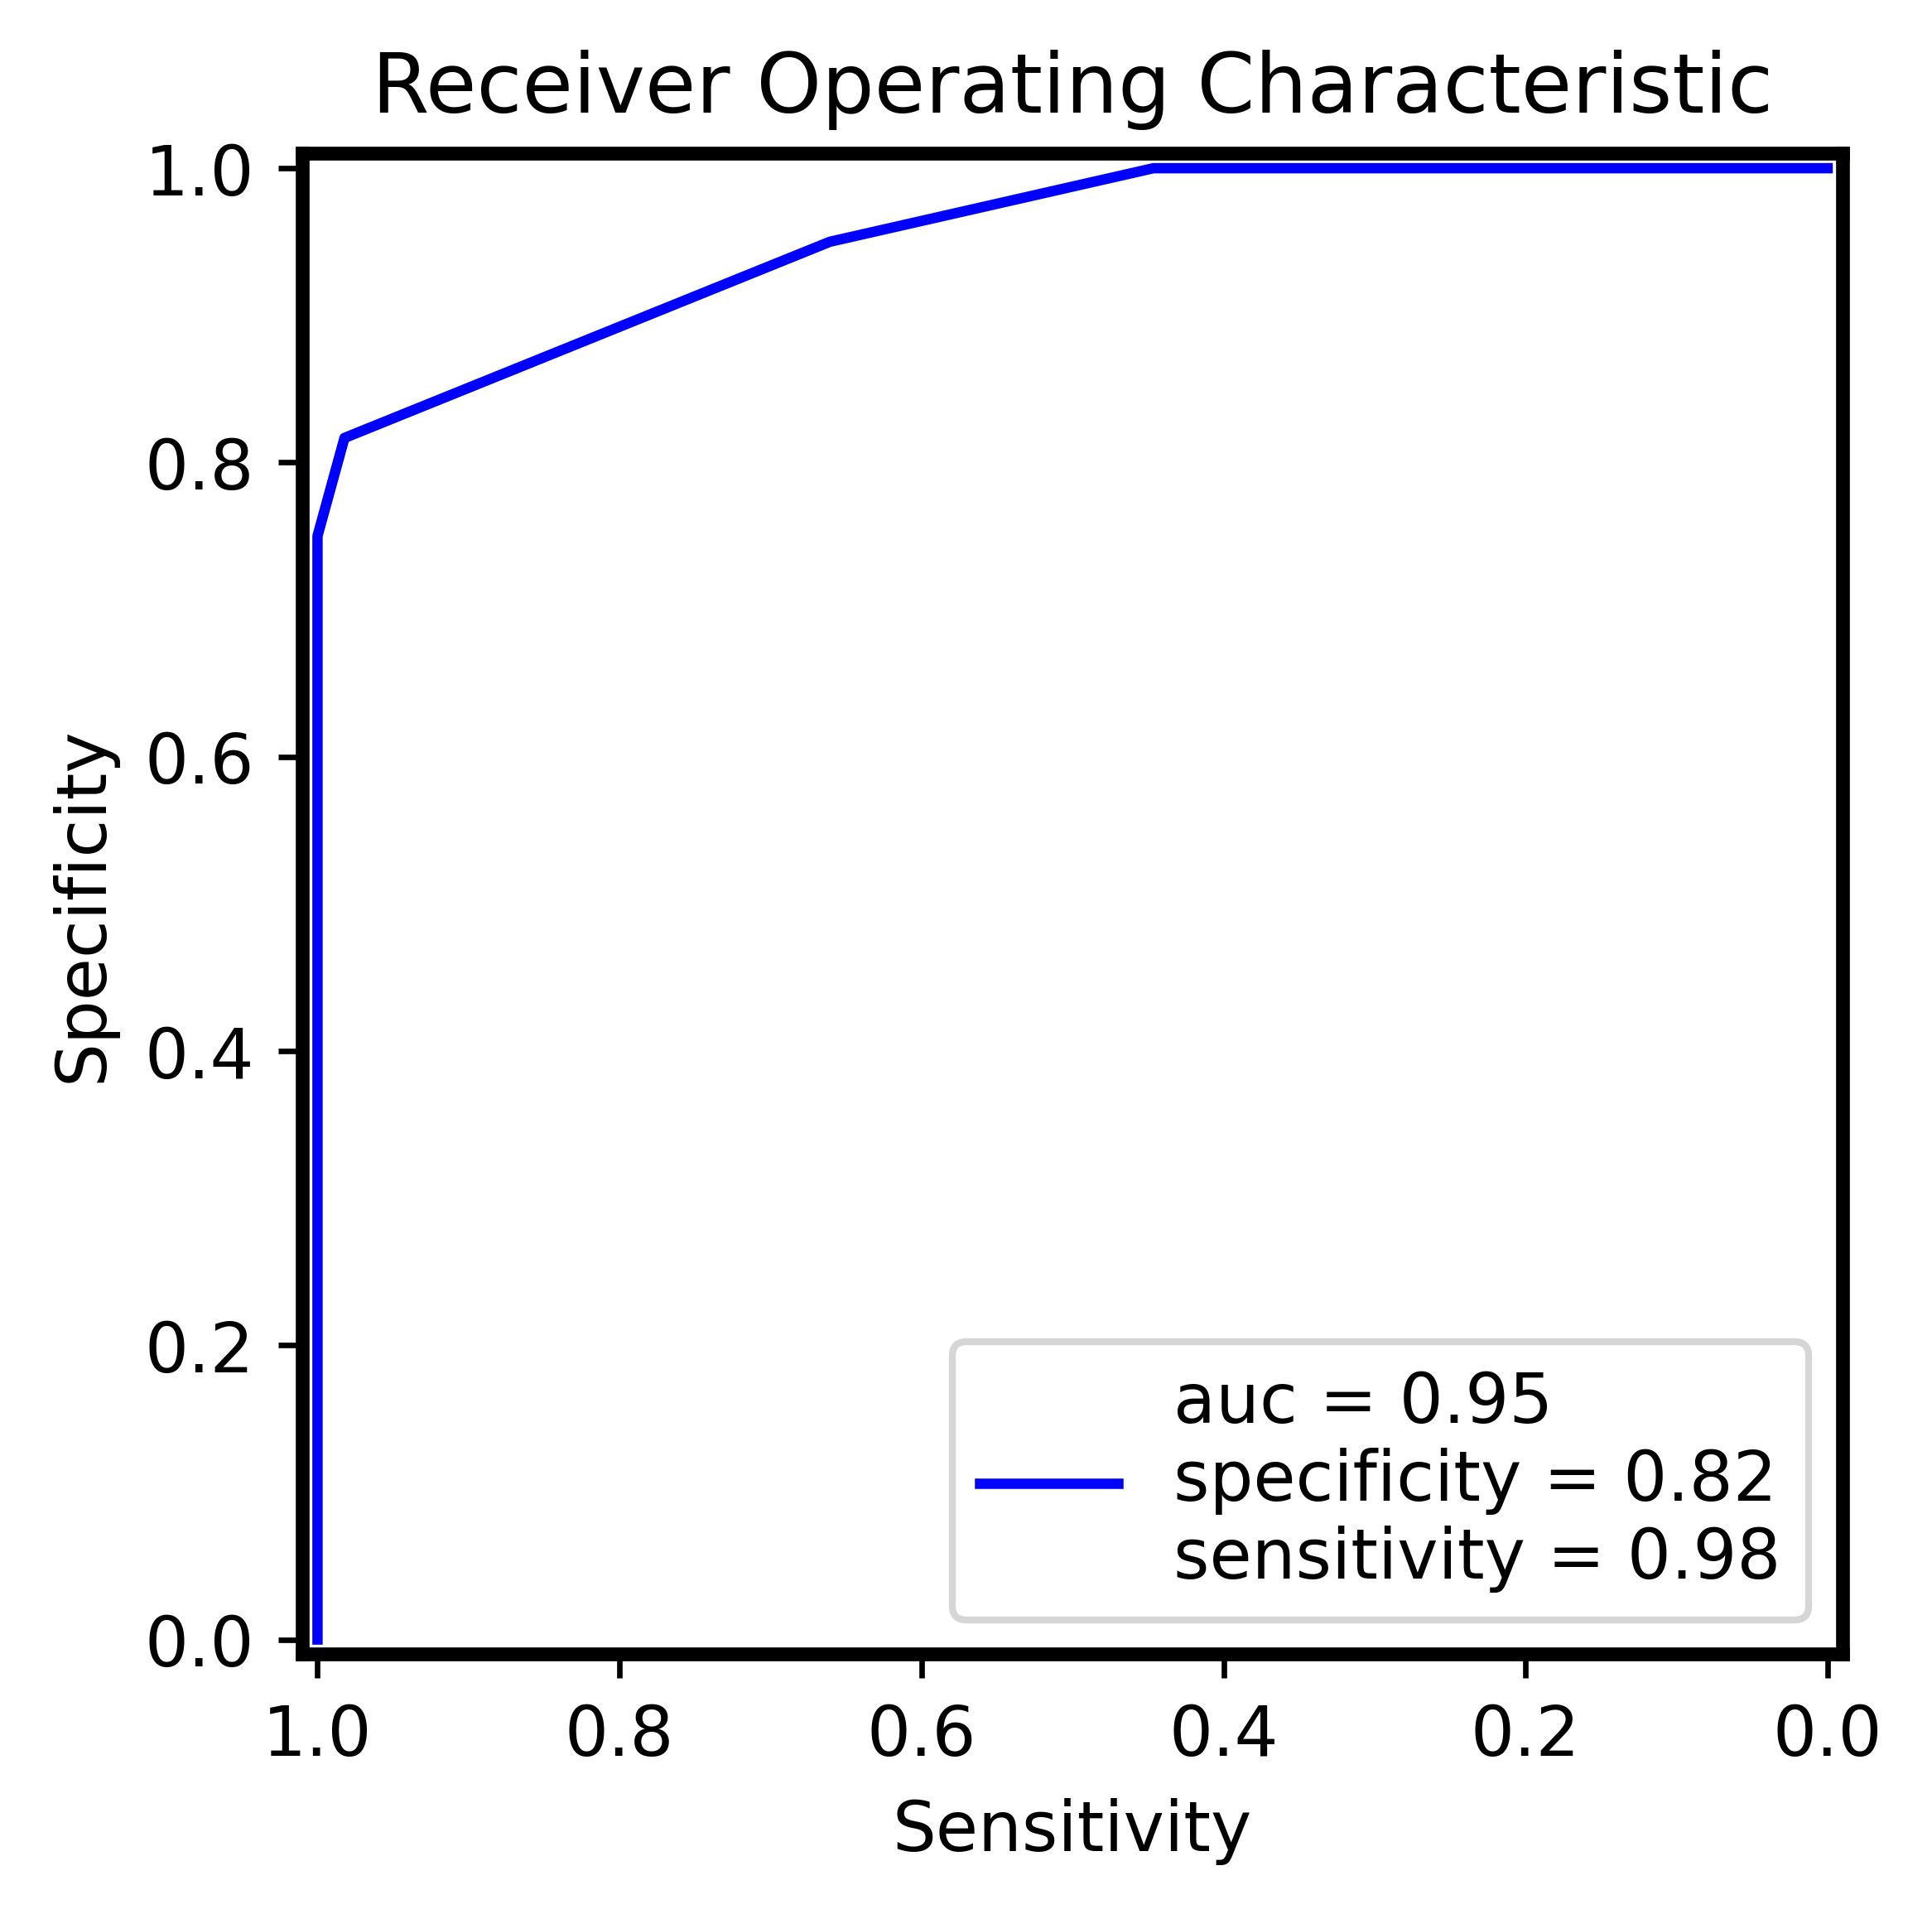

In [202]:
biomarker_evaluate = Biomarker_Evaluate(ns['pred'],model_probs[ModelType.DT])
pred_roc,pred_pr,pspcrp_evaluate = biomarker_evaluate.evaluate()
biomarker_evaluate.plot_roc('ns_dt_crp_psp_roc_plot.png')

In [231]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=2,max_features='log2',min_samples_leaf=1,splitter='random')


In [232]:
clf.fit(ns[['CRP','PSP']],ns['pred'])

DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features='log2',
                       splitter='random')

In [233]:
from sklearn import tree

[Text(0.5, 0.8333333333333334, 'X[1] <= 398.958\nentropy = 0.999\nsamples = 116\nvalue = [56, 60]'),
 Text(0.25, 0.5, 'X[0] <= 4593.149\nentropy = 0.992\nsamples = 87\nvalue = [48, 39]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.982\nsamples = 83\nvalue = [48, 35]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.75, 0.5, 'X[0] <= 1960.483\nentropy = 0.85\nsamples = 29\nvalue = [8, 21]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.863\nsamples = 28\nvalue = [8, 20]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]')]

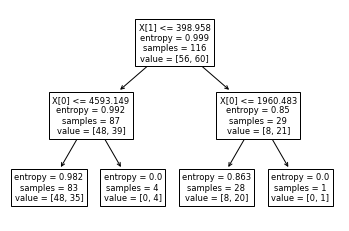

In [234]:
tree.plot_tree(clf)

In [235]:
clf.predict_proba(ns[['CRP','PSP']])[:,1]

array([0.71428571, 0.42168675, 0.42168675, 0.42168675, 0.71428571,
       0.42168675, 0.42168675, 0.42168675, 0.42168675, 0.42168675,
       0.42168675, 0.42168675, 0.71428571, 0.42168675, 0.42168675,
       0.42168675, 0.42168675, 0.42168675, 0.71428571, 0.42168675,
       0.42168675, 0.42168675, 0.71428571, 0.42168675, 0.42168675,
       0.42168675, 0.71428571, 0.42168675, 0.42168675, 0.42168675,
       0.42168675, 0.42168675, 0.42168675, 0.42168675, 0.42168675,
       0.42168675, 0.42168675, 0.71428571, 0.42168675, 0.42168675,
       0.42168675, 0.42168675, 0.42168675, 0.42168675, 0.42168675,
       0.42168675, 0.42168675, 0.42168675, 0.71428571, 0.42168675,
       0.42168675, 0.42168675, 0.42168675, 0.42168675, 0.42168675,
       0.42168675, 0.42168675, 0.42168675, 0.71428571, 0.71428571,
       0.42168675, 0.42168675, 0.42168675, 0.42168675, 0.42168675,
       0.71428571, 0.42168675, 0.71428571, 0.42168675, 0.42168675,
       0.42168675, 0.42168675, 0.42168675, 0.71428571, 0.42168

In [236]:
biomarker_evaluate = Biomarker_Evaluate(ns['pred'],clf.predict_proba(ns[['CRP','PSP']])[:,1])

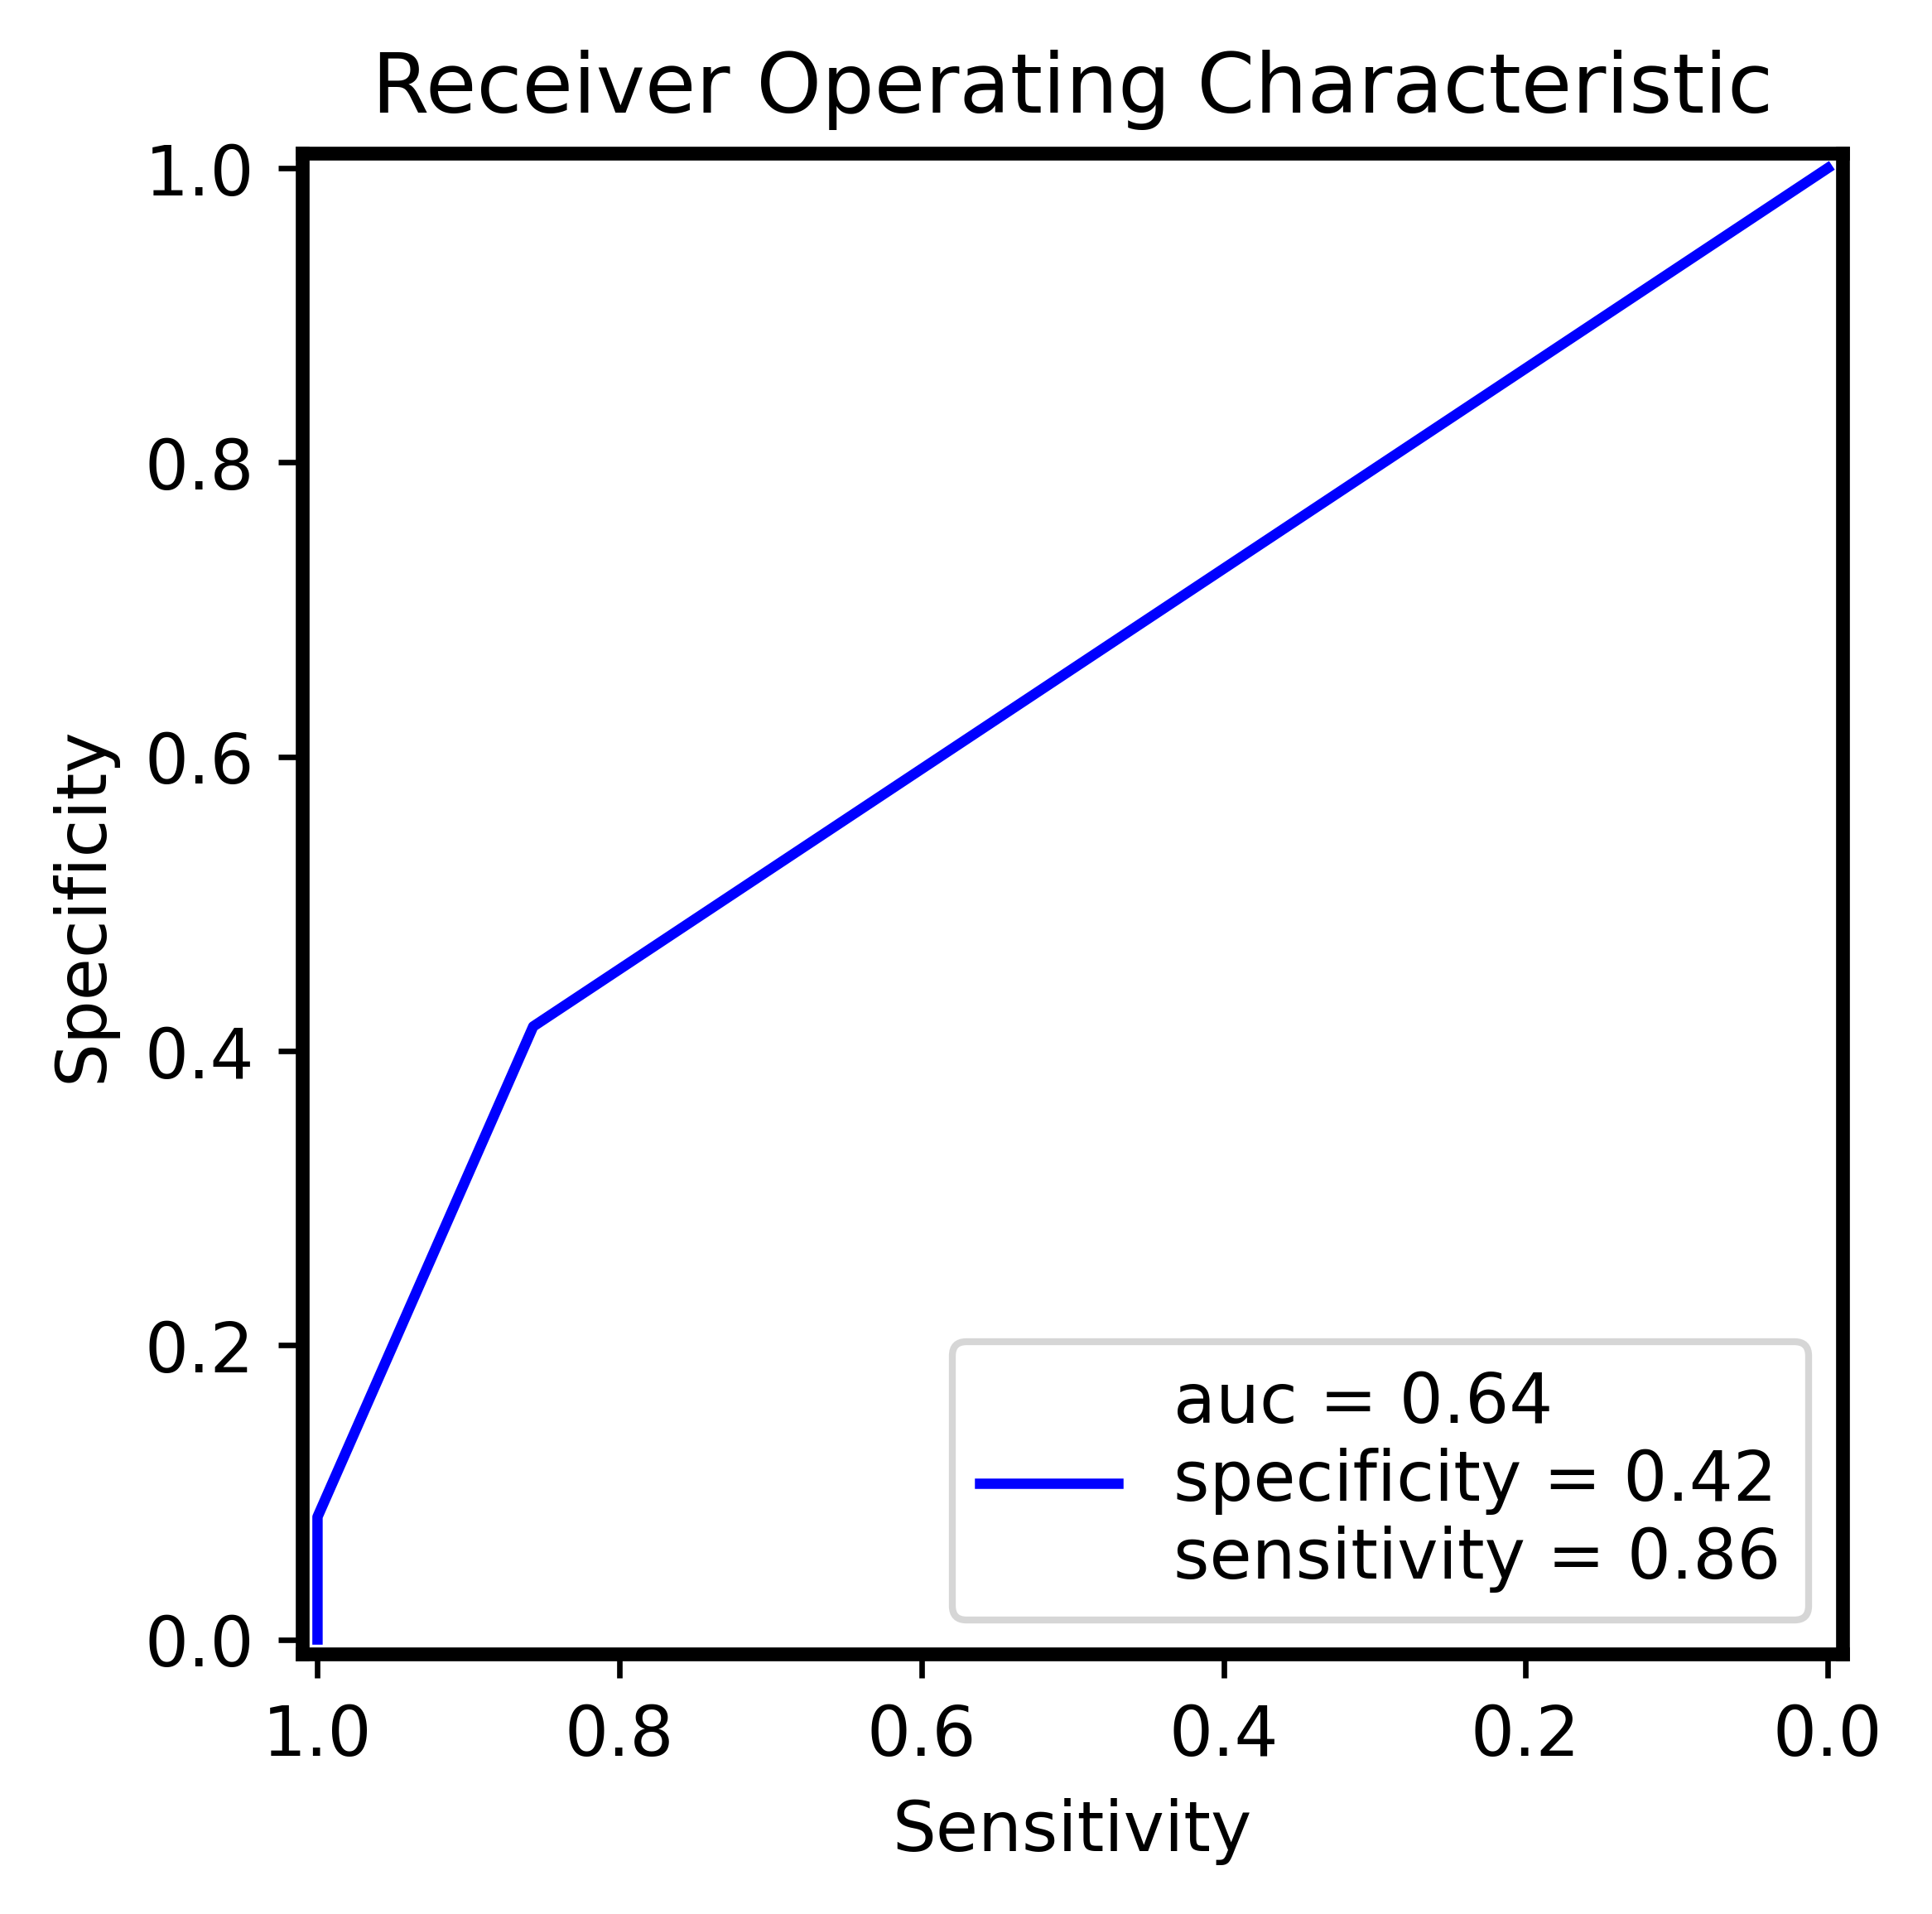

In [237]:
pred_roc,pred_pr,pspcrp_evaluate = biomarker_evaluate.evaluate()
biomarker_evaluate.plot_roc('test_dt_crp_psp_roc_plot.png')

In [278]:
scatterdata = cs[['PSP','CRP','pred']]

In [279]:
scatterdata = pd.concat([scatterdata,pd.DataFrame([0]*scatterdata.shape[0],columns=['con'],index = scatterdata.index)],axis=1)

In [287]:
scatterdata.sort_values('CRP',inplace=True,ascending=False)

In [288]:
scatterdata

PSP           CRP  pred  con
S51   150.0  39043.817227   1.0    0
S52   113.5  23508.090530   1.0    0
S24   137.5  19331.546707   1.0    0
S25    27.0   8845.296992   1.0    0
S50   500.0   2065.331704   1.0    0
...     ...           ...   ...  ...
T130   50.5      0.380000   0.0    0
T87    43.5      0.350000   0.0    0
T28    67.0      0.340000   0.0    0
T2     54.5      0.340000   0.0    0
T82    45.0      0.330000   0.0    0

[264 rows x 4 columns]

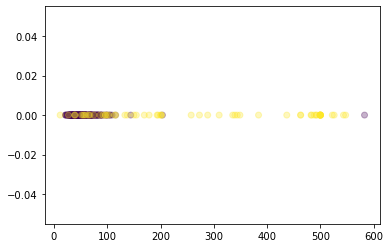

In [283]:
plt.scatter(scatterdata['PSP'],scatterdata['con'],c=scatterdata['pred'],alpha = 0.3)

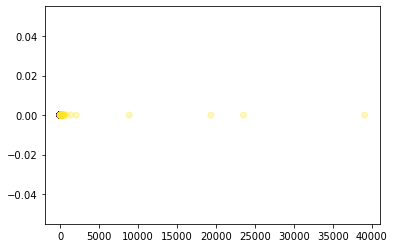

In [284]:
plt.scatter(scatterdata['CRP'],scatterdata['con'],c=scatterdata['pred'],alpha = 0.3)

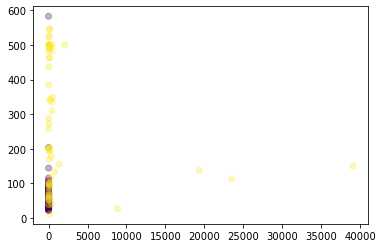

In [285]:
plt.scatter(scatterdata['CRP'],scatterdata['PSP'],c=scatterdata['pred'],alpha = 0.3)

In [298]:
X_train = ns[['PSP','CRP']]
y_train = ns['pred']
X_test = ns[['PSP','CRP']]
y_test = ns['pred']

In [299]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
# Train a decision tree classifier on the training set
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC:', roc_auc)

# Extract the decision tree rules
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "X[%s]" % tree_.feature[i]
        for i in tree_.feature
    ]
    rules = []

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != -2:
            threshold = tree_.threshold[node]
            feature = feature_name[node]
            rules.append((feature, '<=', threshold))
            recurse(tree_.children_left[node], depth + 1)
            rules.append((feature, '>', threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            rules.append(('class', '=', np.argmax(tree_.value[node])))

    recurse(0, 0)
    return rules

rules = tree_to_code(clf, ['PSP', 'CRP'])
print('Decision tree rules:')
for rule in rules:
    print(rule)

# Find the optimal threshold values for the two features
thresholds = {}
for rule in rules:
    if rule[0] == 'feature1':
        if rule[1] == '<=':
            thresholds['feature1_min'] = rule[2]
        else:
            thresholds['feature1_max'] = rule[2]
    elif rule[0] == 'feature2':
        if rule[1] == '<=':
            thresholds['feature2_min'] = rule[2]
        else:
            thresholds['feature2_max'] = rule[2]

print('Optimal threshold values:', thresholds)

ROC AUC: 0.7822916666666666
Decision tree rules:
('CRP', '<=', 44.20897102355957)
('CRP', '<=', 9.899954319000244)
('class', '=', 0)
('CRP', '>', 9.899954319000244)
('class', '=', 0)
('CRP', '>', 44.20897102355957)
('CRP', '<=', 244.0250015258789)
('class', '=', 1)
('CRP', '>', 244.0250015258789)
('class', '=', 1)
Optimal threshold values: {}


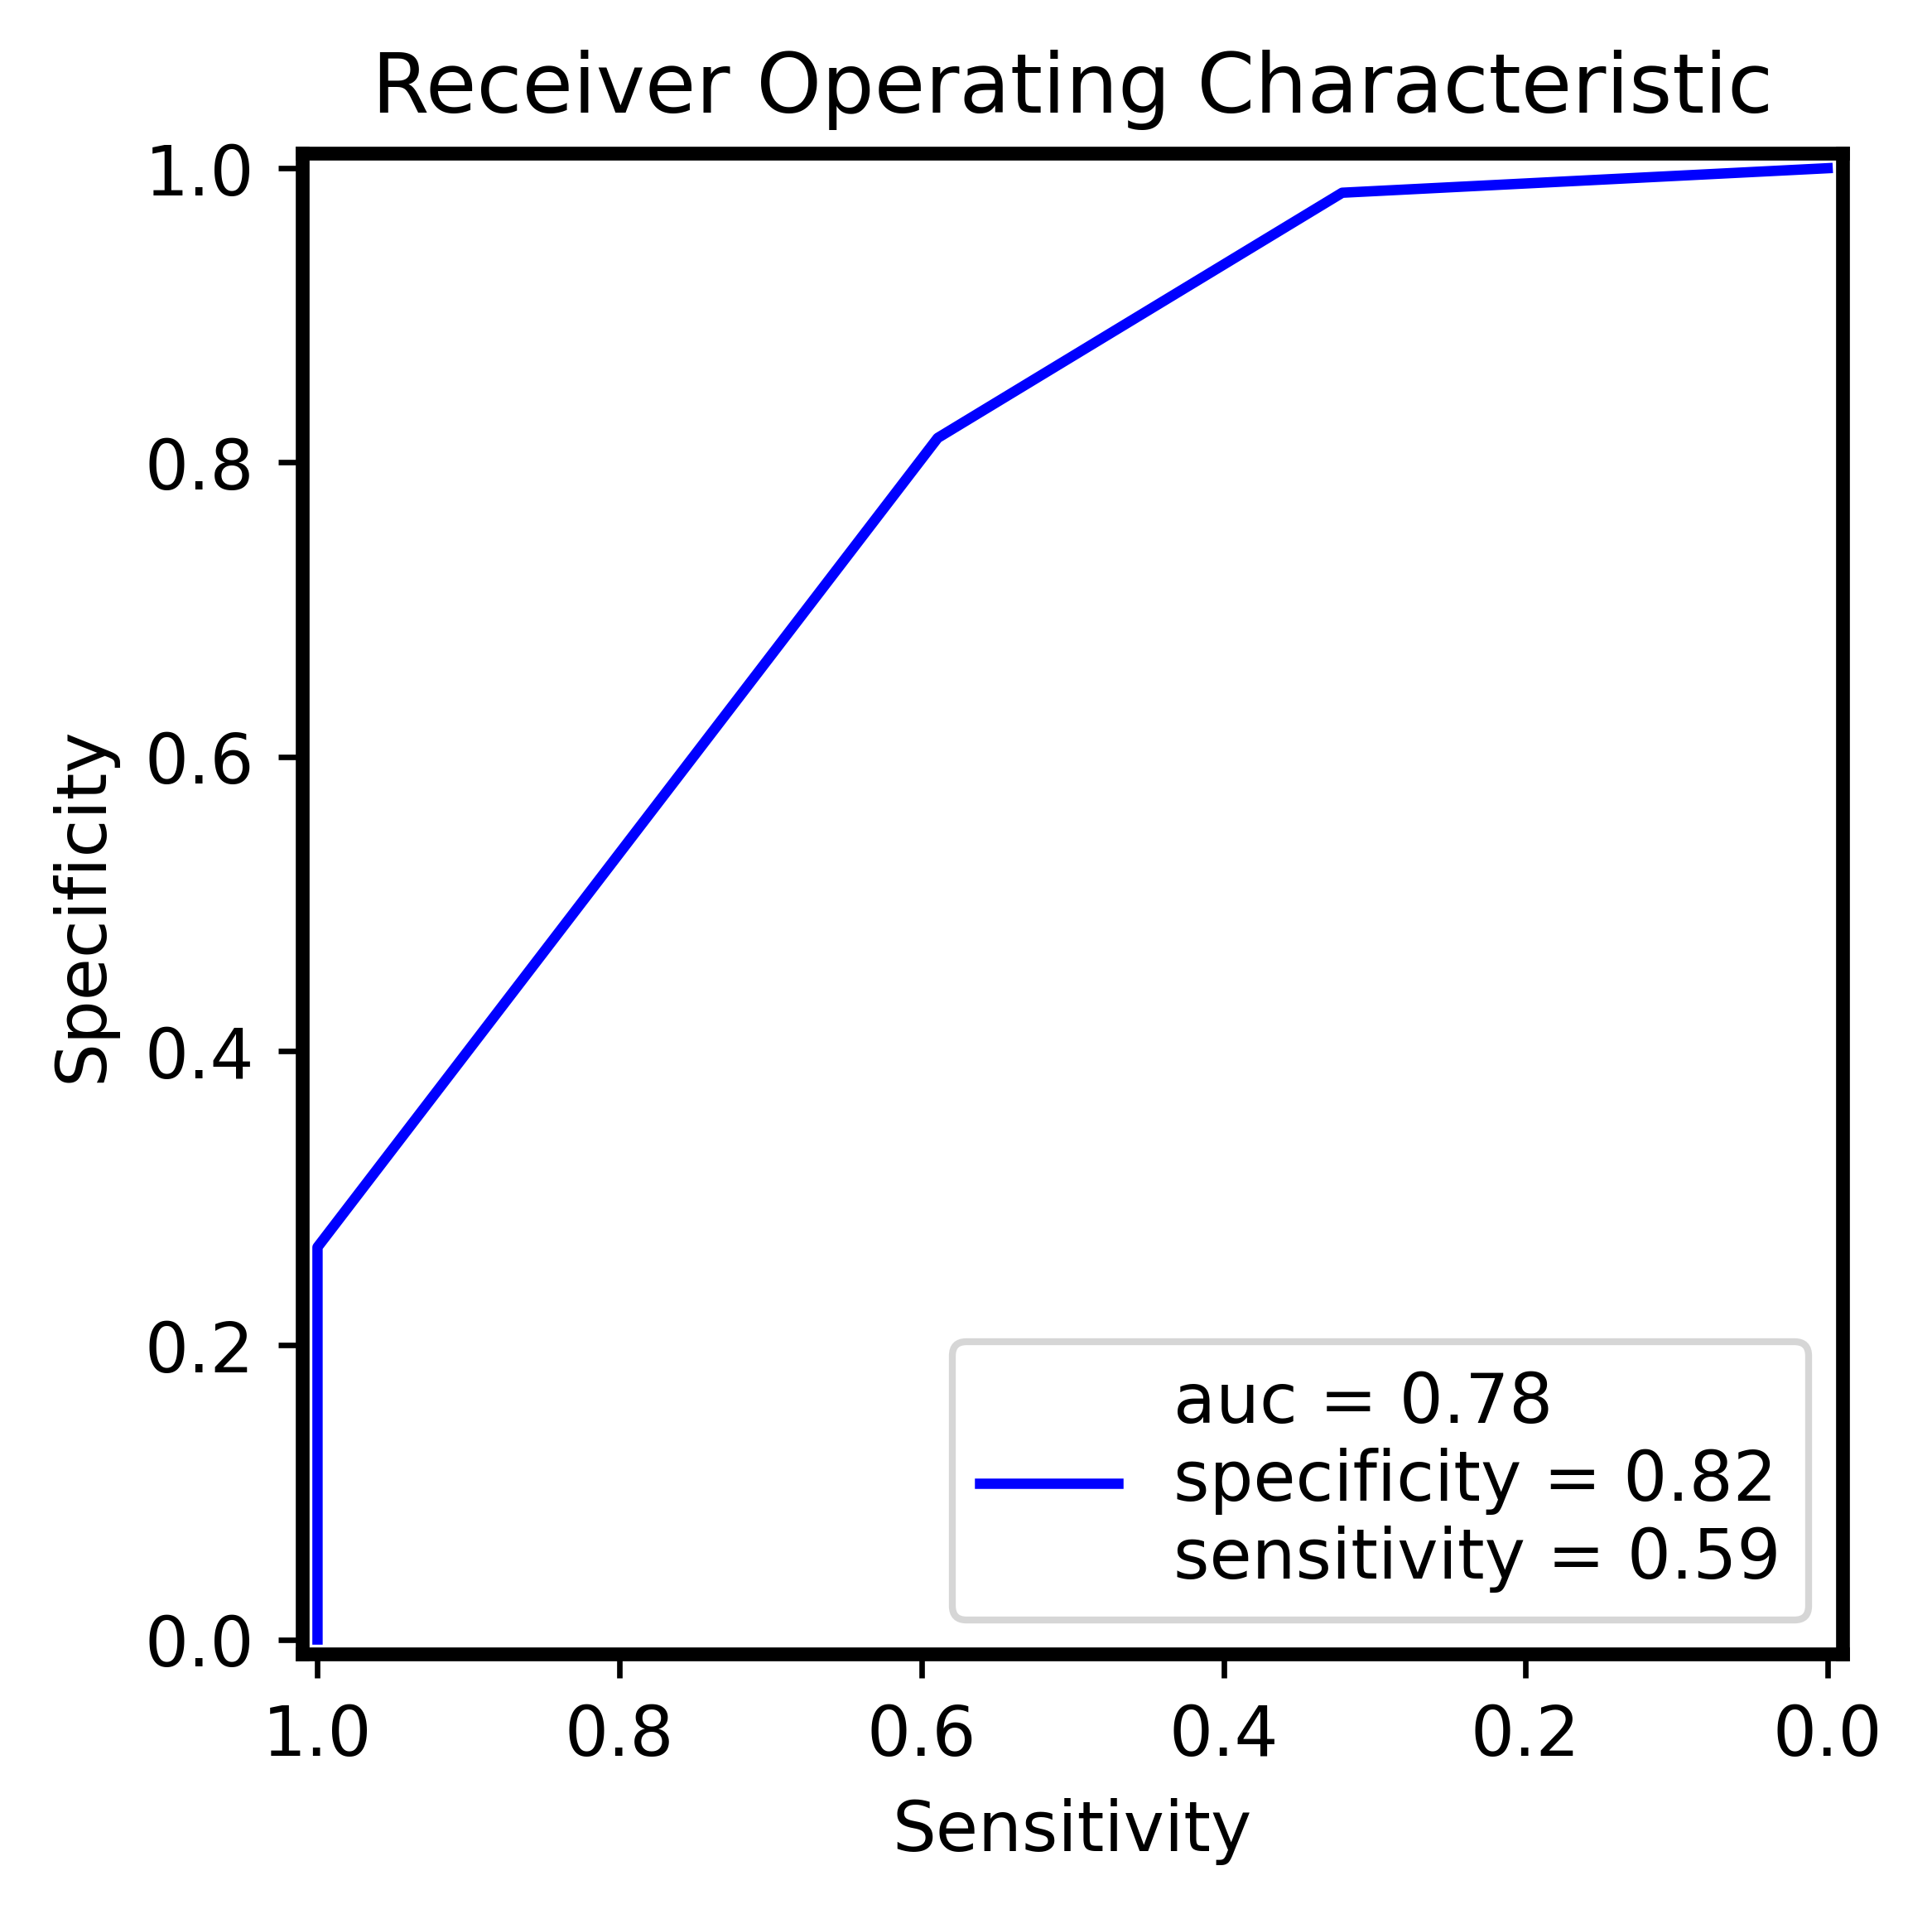

In [300]:
biomarker_evaluate = Biomarker_Evaluate(ns['pred'],y_pred)
pred_roc,pred_pr,pspcrp_evaluate = biomarker_evaluate.evaluate()
biomarker_evaluate.plot_roc('nonsepsis_dt_crp_psp_roc_plot.png')